### Section 1: Import the data and do basic EDA

In [2]:
import dask.dataframe as dd
import pandas as pd
import matplotlib.pyplot as plt

#### two years, elec only, biggest class, unpivot, 49 columns, csv, share

In [4]:
csv_path = r"C:\Users\gerva\OneDrive\Documentos\LONDON SCHOOL OF ECONOMICS\ST498 CAPSTONE PROJECT\7591elec_filtered.csv"
df_filtered = pd.read_csv(csv_path)
print(df_filtered.head())

   ANON_ID   ADVANCEDATETIME  HH  ELECKWH
0     5110  15FEB08:12:30:00  25     0.60
1    11617  15FEB08:12:30:00  25     0.25
2     9015  15FEB08:12:30:00  25     0.40
3    11628  15FEB08:12:30:00  25     0.85
4    11158  15FEB08:12:30:00  25     0.20


In [6]:
df_filtered['ADVANCEDATETIME'] = pd.to_datetime(df_filtered['ADVANCEDATETIME'], format='%d%b%y:%H:%M:%S')

def get_day_class(day):
    if day == 0:  # Monday
        return 1
    elif day in [1, 2, 3]:  # Tuesday, Wednesday, Thursday
        return 2
    elif day == 4:  # Friday
        return 3
    elif day == 5:  # Saturday
        return 4
    elif day == 6:  # Sunday
        return 5

def get_month_class(month):
    if month in [12, 1, 2]:  # Dec, Jan, Feb
        return 1
    elif month == 3:  # March
        return 2
    elif month in [4, 5]:  # April, May
        return 3
    elif month in [6, 7, 9]:  # June, July, September
        return 4
    elif month == 8:  # August
        return 5
    elif month == 10:  # October
        return 6
    elif month == 11:  # November
        return 7

df_filtered['Day_Class'] = df_filtered['ADVANCEDATETIME'].dt.weekday.apply(get_day_class)
df_filtered['Month_Class'] = df_filtered['ADVANCEDATETIME'].dt.month.apply(get_month_class)

# Dictionary of DF
df_filtered_dict = {}

# Group by Day_Class and Month_Class and compute the mean electricity consumption per household
for x in range(1, 6):  
    for y in range(1, 8):  
        df_name = f"df_filtered{x}{y}"  
        df_filtered_dict[df_name] = (
            df_filtered[(df_filtered['Day_Class'] == x) & (df_filtered['Month_Class'] == y)]
            .groupby(['ANON_ID', 'HH'])['ELECKWH']
            .mean()
            .reset_index()
        )


ModuleNotFoundError: No module named 'ace_tools'

In [20]:
import os

# Define output folder
output_folder = r"C:\Users\gerva\OneDrive\Documentos\GitHub\ST498_CAPSTONE\PivotedClassEDRP"

# Dictionary to store pivoted dataframes
df_filtered_pivot_dict = {}

# Loop through all df_filtered_XY DataFrames
for x in range(1, 6):  # Day Classes 1 to 5
    for y in range(1, 8):  # Month Classes 1 to 7
        df_name = f"df_filtered{x}{y}"  
        
        if df_name in df_filtered_dict:  # Ensure the DataFrame exists
            # Pivot oHH
            df_pivot = df_filtered_dict[df_name].pivot(index='ANON_ID', columns='HH', values='ELECKWH')
            
            # Rename columns to HH_00, HH_01, ..., HH_47 
            df_pivot.columns = [f'HH_{int(col):02d}' for col in df_pivot.columns]
            df_pivot.reset_index(inplace=True)
            df_filtered_pivot_dict[f"{df_name}_pivot"] = df_pivot

            # Save to CSV
            output_path = os.path.join(output_folder, f"{df_name}_pivot.csv")
            df_pivot.to_csv(output_path, index=False)

            print(f"Saved: {df_name}_pivot.csv")  # Confirmation message




Saved: df_filtered11_pivot.csv
Saved: df_filtered12_pivot.csv
Saved: df_filtered13_pivot.csv
Saved: df_filtered14_pivot.csv
Saved: df_filtered15_pivot.csv
Saved: df_filtered16_pivot.csv
Saved: df_filtered17_pivot.csv
Saved: df_filtered21_pivot.csv
Saved: df_filtered22_pivot.csv
Saved: df_filtered23_pivot.csv
Saved: df_filtered24_pivot.csv
Saved: df_filtered25_pivot.csv
Saved: df_filtered26_pivot.csv
Saved: df_filtered27_pivot.csv
Saved: df_filtered31_pivot.csv
Saved: df_filtered32_pivot.csv
Saved: df_filtered33_pivot.csv
Saved: df_filtered34_pivot.csv
Saved: df_filtered35_pivot.csv
Saved: df_filtered36_pivot.csv
Saved: df_filtered37_pivot.csv
Saved: df_filtered41_pivot.csv
Saved: df_filtered42_pivot.csv
Saved: df_filtered43_pivot.csv
Saved: df_filtered44_pivot.csv
Saved: df_filtered45_pivot.csv
Saved: df_filtered46_pivot.csv
Saved: df_filtered47_pivot.csv
Saved: df_filtered51_pivot.csv
Saved: df_filtered52_pivot.csv
Saved: df_filtered53_pivot.csv
Saved: df_filtered54_pivot.csv
Saved: d

 ### Import data

In [2]:
# Add the path to your working directory of where your capstone stuff is on your machine so we can all use the same relative paths below 

fin_wd = '/Users/finbarrhodes/Documents/Capstone/EDRP/'
g_wd = r"C:/Users/gerva/OneDrive/Documentos/LONDON SCHOOL OF ECONOMICS\ST498 CAPSTONE PROJECT/"

In [3]:
# raw data path
csv_path = fin_wd + r"/csv/edrp_elec.csv"

# read csv as dask df
raw_data = dd.read_csv(csv_path)
print(raw_data.head())

   ANON_ID   ADVANCEDATETIME  HH  ELECKWH
0     5110  15FEB08:12:30:00  25     0.60
1    11617  15FEB08:12:30:00  25     0.25
2     4869  15FEB08:12:30:00  25     0.30
3     9015  15FEB08:12:30:00  25     0.40
4    11628  15FEB08:12:30:00  25     0.85


## Data Preprocessing

Preprocessing Steps:
- Just 2009 data
- Electric fuel type households
- Cut holiday outlier times (Dec 23 - Jan 2)
- Cut ANON_IDs without full readings at every HH interval
- Cut ANON_IDs with less than .1 kWH average consumption


Filtering to year 2009 and ANON_IDs that have 'ElecOnly' from the metafile. Only run once to get file(s) saved to your computer.



In [4]:
# get ADVANCEDATETIME in datetime format
raw_data['ADVANCEDATETIME'] = pd.to_datetime(raw_data['ADVANCEDATETIME'], format='%d%b%y:%H:%M:%S')
raw_data['Year'] = raw_data['ADVANCEDATETIME'].dt.year

: 

: 

In [ ]:
# just want 2009 data for now
raw_2009 = raw_data[raw_data['Year'] == 2009]

In [ ]:
# geographic metadata path 
geo_path = fin_wd + r"csv/edrp_geography_data.xlsx"
df_geo = pd.read_excel(geo_path)

# get anonIDs with 'ElecOnly' fuel types
elec_only_ids = set(df_geo[df_geo['fuelTypes'] == 'ElecOnly']['anonID'])
raw_2009 = raw_2009[raw_2009['ANON_ID'].isin(elec_only_ids)]

In [ ]:
# write csv for 2009 data
output_path = fin_wd + r"csv/7591elec_2009.csv"
raw_2009.to_csv(output_path, index=False)

print(f"2009 electricity data has been saved to: {output_path}")

Reading in 2009 electric-only CSV

In [ ]:
# raw data path
path = fin_wd + r"csv/7591elec_2009.csv"
# read csv as dask df
df_2009 = dd.read_csv(path)
print(df_2009.head())

#### Distribution of ANON_ID Meter Readings 

Plotting meter reading frequency by ANON_ID

In [ ]:
# Count the frequency of ANON_IDs
anon_id_counts = df_2009['ANON_ID'].value_counts()

# Plot the histogram
plt.figure(figsize=(12, 8))
plt.hist(anon_id_counts, bins=40, color='skyblue', edgecolor='black', alpha=0.7)
plt.title('Histogram of Record Frequency per ANON_ID', fontsize=16)
plt.xlabel('Number of Records', fontsize=14)
plt.ylabel('Frequency of ANON_IDs', fontsize=14)
plt.grid(axis='y', alpha=0.75)
plt.tight_layout()
plt.show()


Cutting the IDs with low meter reading counts

In [ ]:
# cutting anon_ids below 12000 total readings 
anon_id_counts = df_2009['ANON_ID'].value_counts()
valid_anon_ids = anon_id_counts[anon_id_counts >= 12000].index
df_2009 = df_2009.reset_index(drop=True)



# excluding holiday outlier times
df_2009['ADVANCEDATETIME'] = dd.to_datetime(df_2009['ADVANCEDATETIME'], format='%d%b%y:%H:%M:%S', errors='coerce')
df_2009['Year'] = df_2009['ADVANCEDATETIME'].dt.year
df_2009['Month'] = df_2009['ADVANCEDATETIME'].dt.month
df_2009['Day'] = df_2009['ADVANCEDATETIME'].dt.day

condition = ~(
    ((df_2009['Month'] == 12) & (df_2009['Day'] >= 23)) |  # 23 Dec to 31 Dec
    ((df_2009['Month'] == 1) & (df_2009['Day'] <= 2))     # 1 Jan to 2 Jan
)
df_2009 = df_2009[condition]

In [ ]:
print(df_2009.head())

Empty DataFrame
Columns: [ANON_ID, ADVANCEDATETIME, HH, ELECKWH, Day, Season, Month, Year]
Index: []


Incorporating seasons, ensuring numerical values where needed, and cutting households without readings at every half-hour interval.

In [ ]:

# defining function to assign seasons 
def get_season(month):
    if month in [12, 1, 2]:
        return 2 #'Winter'
    elif month in [3, 4, 5]:
        return 3 # 'Spring'
    elif month in [6, 7, 8]:
        return 0 # Summer
    else:
        return 1 # 'Fall'
    
df_2009['Month'] = df_2009['ADVANCEDATETIME'].dt.month
df_2009['Season'] = df_2009['Month'].apply(get_season)

# dropping now-unnecessary columns
df_2009 = df_2009.drop(columns=['Month', 'Year'])


# ensuring all numeric entries in columns that should have them
columns_to_check = ['ANON_ID', 'HH', 'ELECKWH']
for col in columns_to_check:
    df_2009[col] = pd.to_numeric(df_2009[col], errors='coerce')
df_2009 = df_2009.dropna(subset=columns_to_check)
df_2009 = df_2009.reset_index(drop=True)



# keeping ANON_IDs with entries for all HH values
unique_hh_per_anon = df_2009.groupby('ANON_ID')['HH'].nunique()
valid_anon_ids = dd.from_pandas(unique_hh_per_anon[unique_hh_per_anon == df_2009['HH'].nunique()])
df_2009 = df_2009[df_2009['ANON_ID'].isin(valid_anon_ids)]

/opt/miniconda3/lib/python3.12/site-packages/dask_expr/_collection.py:4409: UserWarning: 
You did not provide metadata, so Dask is running your function on a small dataset to guess output types. It is possible that Dask will guess incorrectly.
To provide an explicit output types or to silence this message, please provide the `meta=` keyword, as described in the map or apply function that you are using.
  Before: .apply(func)
  After:  .apply(func, meta=('Month', 'int64'))

  warnings.warn(meta_warning(meta))


KeyError: "['Year'] not found in axis"

Visualizing average daily consumption across the board

In [ ]:
# getting mean ELECKWH for each ANON_ID
mean_eleckwh_per_anon = df_2009.groupby('ANON_ID')['ELECKWH'].mean()

# plotting the histogram
plt.figure(figsize=(10, 6))
plt.hist(mean_eleckwh_per_anon, bins=50, color='skyblue', edgecolor='black', alpha=0.7)
plt.title('Histogram of Mean ELECKWH per ANON_ID', fontsize=16)
plt.xlabel('Mean ELECKWH', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.grid(axis='y', alpha=0.75)
plt.tight_layout()
plt.show()


Cutting low consumption households (threshold of .1 kWh selected from literature)

In [ ]:
# get ANON_IDs with mean ELECKWH < 0.1 kWh
anon_ids_below_threshold = mean_eleckwh_per_anon[mean_eleckwh_per_anon < 0.1].index.tolist()
count_below_threshold = len(anon_ids_below_threshold)
print(f"Number of ANON_IDs with mean ELECKWH < 0.1: {count_below_threshold}")

# exclude low consumption ids from data
df_2009 = ~df_2009[df_2009['ANON_ID'].isin(anon_ids_below_threshold)]



In [ ]:
# taking a look at preprocessed data
print(df_2009.head())
print(df_2009.shape)
print(f"Number of remaining ANON_IDs: {len(valid_anon_ids)}")


Plotting low consumption households for visualizations sake.

In [ ]:

# geting df of low consumption households
low_kWh = df_2009[df_2009['ANON_ID'].isin(anon_ids_below_threshold)]

# Calculate the average consumption per HH for each ANON_ID
avg_consumption_per_hh = (
    low_kWh.groupby(['ANON_ID', 'HH'])['ELECKWH']
    .mean()
    .reset_index()
    .sort_values(by='HH')
)

# Plot the data
plt.figure(figsize=(12, 8))

# Loop through each ANON_ID and plot their consumption
for anon_id in anon_ids_below_threshold:
    anon_data = avg_consumption_per_hh[avg_consumption_per_hh['ANON_ID'] == anon_id]
    plt.plot(anon_data['HH'], anon_data['ELECKWH'], label=f'ANON_ID: {anon_id}', alpha=0.7)

# Plot details
plt.title('Average Consumption per HH for ANON_IDs with Mean ELECKWH < 0.1')
plt.xlabel('Half Hour of the Day (HH)')
plt.ylabel('Average ELECKWH')
plt.xticks(range(1, 49))  # Assuming HH ranges from 1 to 48
plt.grid(True)

plt.tight_layout()
plt.show

### Feature Selection 


Starting by splitting the day into 4 periods and calculate the mean accordingly. 

The periods are:
* 'bre' - breakfast: 6 - 10
* 'day' - day: 10.30 - 16
* 'eve' - evening: 16.30 - 22
* 'nig' - night: 22.30 - 5.30

In [ ]:
df_2009['Weekend'] = df_2009['ADVANCEDATETIME'].dt.weekday.isin([5, 6]).astype(int)

# function to assign HH to time-of-day split above
def hh_group(hh):
    if 12 <= hh <= 20:
        return 'bre'  # 'breakfast'
    elif 21 <= hh <= 32:
        return 'day'  # 'daytime'
    elif 33 <= hh <= 44:
        return 'eve'  # 'evening'
    else:
        return 'nig'  # 'night'

df_2009['HH_Group'] = df_2009['HH'].map(hh_group)

# calculating mean consumption by ANON_ID, HH_Group, and Weekend
df_2009_means = df_2009.groupby(['ANON_ID', 'HH_Group', 'Weekend'])['ELECKWH'].mean().reset_index()
# Rename the 'ELECKWH' column to 'KWH_by_SeasonTimeWknd'
df_2009_means = df_2009_means.rename(columns={'ELECKWH': 'KWH_by_SeasonTimeWknd'})

# Display the result
print(df_2009_means.head())

   ANON_ID HH_Group  Weekend  KWH_by_SeasonTimeWknd
0        3      bre        0               0.291354
1        3      bre        1               0.269000
2        3      day        0               0.287738
3        3      day        1               0.259158
4        3      eve        0               0.365056


#### Relative Mean Electricity (RME) Consumption 

Based on Slovenian Paper

RME is added by HH_GROUP (bre, day, eve, nig) 

In [ ]:
mean_by_group = (
    df_2009.groupby(['ANON_ID', 'HH_Group'])['ELECKWH']
    .mean()
    .reset_index()
)
mean_overall = (
    df_2009.groupby('ANON_ID')['ELECKWH']
    .mean()
    .reset_index()
)
mean_overall = mean_overall.rename(columns={'ELECKWH': 'Overall_Mean'})

# merging grouped mean with the overall mean
merged = mean_by_group.merge(mean_overall, on='ANON_ID')

# calculating RME
merged['RME'] = merged['ELECKWH'] / merged['Overall_Mean']

# Pivot the table to have RME_bre, RME_day, RME_eve, RME_nig as columns
df_rme = merged.pivot(index='ANON_ID', columns='HH_Group', values='RME').reset_index()
df_rme = df_rme.rename(columns={ 'bre': 'RME_bre', 'day': 'RME_day', 'eve': 'RME_eve','nig': 'RME_nig' })

# Reset index to remove hierarchical indexing (if present)
df_rme.columns.name = None

print(df_rme)

#### Plot for a specific ANON_ID the average daily consumption

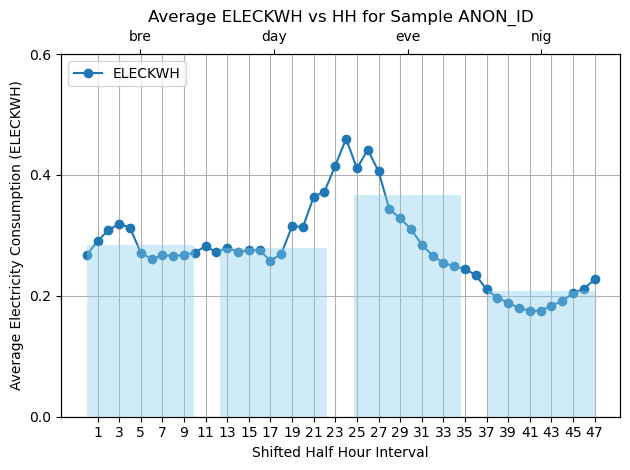

(16537, 10)


In [ ]:
# Prep for plot
df_anon3 = df_2009[df_2009['ANON_ID'] == 3]
df_anon3['Shifted HH'] = df_anon3['HH'].apply(lambda i: i-12 if i>11 else i+36)  # since 'bre' starts at 6am
average_eleckwh_by_hh = df_anon3.groupby('Shifted HH')['ELECKWH'].mean().reset_index()

df_anon3['HH_Group'] = df_anon3['HH'].map(hh_group)
average_eleckwh_by_hh_group = df_anon3.groupby('HH_Group')['ELECKWH'].mean().reset_index()


fig, ax1 = plt.subplots()

# defining plots that will share the same x-axis
plt.plot(
    average_eleckwh_by_hh['Shifted HH'], 
    average_eleckwh_by_hh['ELECKWH'], 
    marker='o', linestyle='-', label='ELECKWH'
)
ax1.set_title('Average ELECKWH vs HH for Sample ANON_ID')
ax1.set_xlabel('Shifted Half Hour Interval')
ax1.set_ylabel('Average Electricity Consumption (ELECKWH)')
ax1.set_xticks(range(1, 49, 2))  # HH ranges from 1 to 48
ax1.set_yticks([0, 0.2, 0.4, 0.6])  # Define y-axis values
ax1.grid(True)
ax1.legend(loc = "upper left")

ax2 = ax1.twiny()

# Overlaying by time-of-day
ax2.bar(
    average_eleckwh_by_hh_group['HH_Group'], 
    average_eleckwh_by_hh_group['ELECKWH'], 
    color='skyblue',
    alpha = .4
)
ax2.set_yticks([0, 0.2, 0.4, 0.6]) 
ax2.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()
print(df_anon3.shape)


#### Time-of-Day and Mean Relative Standard Deviation (RSD)

In [ ]:
# getting mean and standard deviation of consumption levels for each ANON_ID and HH_Group
stats_by_group = (
    df_2009.groupby(['ANON_ID', 'HH_Group'])['ELECKWH']
    .agg(['mean', 'std'])
    .reset_index()
)

# renaming columns for clarity
stats_by_group = stats_by_group.rename(columns={'mean': 'ELECKWH_mean', 'std': 'ELECKWH_std'})

# calculating Relative Standard Deviation (RSD) for each group
stats_by_group['RSD'] = (stats_by_group['ELECKWH_std'] / stats_by_group['ELECKWH_mean'])

# pivoting to have RSD_bre, RSD_day, RSD_eve, RSD_nig as columns
df_rsd_og = stats_by_group.pivot(index='ANON_ID', columns='HH_Group', values='RSD').reset_index()
df_rsd_og = df_rsd_og.rename(columns={'bre': 'RSD_bre','day': 'RSD_day','eve': 'RSD_eve','nig': 'RSD_nig'})
df_rsd_og = df_rsd_og.fillna(0)

# adding average RSD across all HH_Groups
df_rsd_og['RSD_avg'] = df_rsd_og[['RSD_bre', 'RSD_day', 'RSD_eve', 'RSD_nig']].mean(axis=1)

# display the final table
print(df_rsd_og)

# showing top and bottom 5 RSD_avg IDs
top_5_rsd_avg_OG = df_rsd_og.nlargest(5, 'RSD_avg')[['ANON_ID', 'RSD_avg']]
print("Top 5 ANON_IDs with the highest RSD_avg:")
print(top_5_rsd_avg_OG)
bottom_5_rsd_avg_OG = df_rsd_og.nsmallest(5, 'RSD_avg')[['ANON_ID', 'RSD_avg']]
print("Botton 5 ANON_IDs with the highest RSD_avg:")
print(bottom_5_rsd_avg_OG)



HH_Group  ANON_ID   RSD_bre   RSD_day   RSD_eve   RSD_nig   RSD_avg
0               3  0.506724  0.504015  0.535121  0.453364  0.499806
1               5  1.269247  0.757445  0.631437  0.616402  0.818633
2               7  1.146724  1.395079  0.850413  0.416317  0.952133
3               8  1.059533  1.089155  0.769973  0.600383  0.879761
4              10  1.329203  1.406260  1.348616  1.715313  1.449848
...           ...       ...       ...       ...       ...       ...
4723        16240  0.988811  1.050333  0.731271  0.970981  0.935349
4724        16242  0.497199  0.731927  0.517889  0.396493  0.535877
4725        16244  1.016719  1.019673  0.580458  0.802500  0.854837
4726        16247  1.967350  1.590546  1.158294  1.448259  1.541112
4727        16248  0.875949  0.765020  0.544156  0.923331  0.777114

[4728 rows x 6 columns]
Top 5 ANON_IDs with the highest RSD_avg:
HH_Group  ANON_ID   RSD_avg
3525        12237  5.004532
621          2177  3.129625
3208        11138  2.682589
2238  

#### Seasonal Score

In [ ]:
# dropping unnecessary columns for this chunk
df_2009a = df_2009.drop(columns=['Month', 'Weekend', 'Day'])

season_means = df_2009a.groupby(['ANON_ID', 'HH_Group', 'Season'])['ELECKWH'].mean().reset_index()

# pivot seasonal means to have summer and winter columns 
season_pivot = season_means.pivot_table(index=['ANON_ID', 'HH_Group'], columns='Season', values='ELECKWH').reset_index()
season_pivot = season_pivot.rename(columns={0: 'mean_summer', 2: 'mean_winter'})

# getting overall mean for each ANON_ID across time-of-day split
overall_means = df_2009.groupby(['ANON_ID', 'HH_Group'])['ELECKWH'].mean().reset_index()
overall_means = overall_means.rename(columns={'ELECKWH': 'mean_hh_group'})

# merge overall means and season pivot table
merged = season_pivot.merge(overall_means, on=['ANON_ID', 'HH_Group'])

# difference across seasons proportional to the average demand
merged['Difference'] = (merged['mean_winter'] - merged['mean_summer']) / merged['mean_hh_group']

# average difference across HH_Groups for all IDs
df_season_diff = merged.groupby('ANON_ID')['Difference'].mean().reset_index()
df_season_diff = df_season_diff.rename(columns={'Difference': 'Seasonal_Difference'})

print(df_season_diff.head())


   ANON_ID  Seasonal_Difference
0        3            -0.176808
1        5             0.084449
2        7             0.368460
3        8             0.156239
4       10             1.730239


#### Weekend Score


In [ ]:

# defining 'Weekend' column (1 for weekend, 0 for weekday)
df_2009['Weekend'] = df_2009['ADVANCEDATETIME'].dt.weekday.isin([5, 6]).astype(int)

# getting means on weekend across times of day for each ID 
weekend_means = (df_2009.groupby(['ANON_ID', 'HH_Group', 'Weekend'])['ELECKWH'].mean().reset_index())

# making separate columns for weekday (0) and weekend (1) means
weekend_pivot = (weekend_means.pivot_table(index=['ANON_ID', 'HH_Group'], columns='Weekend', values='ELECKWH').reset_index())
weekend_pivot = weekend_pivot.rename(columns={0: 'mean_weekday', 1: 'mean_weekend'})

# getting overall mean for each ANON_ID across time-of-day split
overall_means = (df_2009.groupby(['ANON_ID', 'HH_Group'])['ELECKWH'].mean().reset_index().rename(columns={'ELECKWH': 'mean_hh_group'}))

# merging overall means with weekday/weekend pivot table
merged = weekend_pivot.merge(overall_means, on=['ANON_ID', 'HH_Group'])

# difference across weekend/weekday proportional to the average demand
merged['Difference'] = (merged['mean_weekend'] - merged['mean_weekday']) / merged['mean_hh_group']

# average difference across HH_Groups for all IDs
df_weekday_weekend_diff = (merged.groupby('ANON_ID')['Difference'].mean().reset_index().rename(columns={'Difference': 'Weekday_Weekend_Difference'}))

print(df_weekday_weekend_diff.tail())


      ANON_ID  Weekday_Weekend_Difference
4723    16240                    0.015024
4724    16242                   -0.069638
4725    16244                   -0.172709
4726    16247                   -0.180068
4727    16248                    0.144316


Join the dataframes to get per ANONID all the relevant features based only on its consumption.

In [ ]:
df_rsd_reduced = df_rsd_og[['ANON_ID', 'RSD_avg']]

# merging df_rme with df_season_diff
df_2009_features = df_rme.merge(df_season_diff, on='ANON_ID', how='left')
df_2009_features = df_2009_features.merge(df_weekday_weekend_diff, on='ANON_ID', how='left')

# merging with df_rsd_reduced to add RSD_avg
df_2009_features = df_2009_features.merge(df_rsd_reduced, on='ANON_ID', how='left')

# renaming
df_2009_features = df_2009_features.rename(columns={'Seasonal_Difference': 'SScore'})# Rename the column for clarity
df_2009_features = df_2009_features.rename(columns={'Weekday_Weekend_Difference': 'WScore'})

# getting date from ADVANCEDATETIME
df_2009['Date'] = df_2009['ADVANCEDATETIME'].dt.date

# daily max-min difference
daily_stats = df_2009.groupby(['ANON_ID', 'Date'])['ELECKWH'].agg(['max', 'min']).reset_index()
daily_stats['Daily_Max_Min_Diff'] = daily_stats['max'] - daily_stats['min'] 

# average daily max-min difference for each ID
avg_daily_diff = daily_stats.groupby('ANON_ID')['Daily_Max_Min_Diff'].mean().reset_index()
avg_daily_diff = avg_daily_diff.rename(columns={'Daily_Max_Min_Diff': 'ADR'})

#  average consumption for 'day' and 'eve' time periods
df_day_eve = df_2009[df_2009['HH_Group'].isin(['day', 'eve','bre','nig'])]
day_eve_avg = df_day_eve.groupby(['ANON_ID', 'Date'])['ELECKWH'].mean().reset_index()
avg_day_eve = day_eve_avg.groupby('ANON_ID')['ELECKWH'].mean().reset_index()
avg_day_eve = avg_day_eve.rename(columns={'ELECKWH': 'Avg_Day_Eve'})

# merging new features in 
df_2009_features = pd.merge(df_2009_features, avg_daily_diff, on='ANON_ID', how='left')
df_2009_features = pd.merge(df_2009_features, avg_day_eve, on='ANON_ID', how='left')

'''
#Drop RSD_avg greater than 2
df_2009_features = df_2009_features[df_2009_features['RSD_avg'] <= 2.2]
df_2009_features = df_2009_features.reset_index(drop=True)
'''

print(df_2009_features.tail())


      ANON_ID   RME_bre   RME_day   RME_eve   RME_nig    SScore    WScore  \
4723    16240  1.105578  1.125335  1.556399  0.390474  0.122849  0.015024   
4724    16242  0.809831  1.198649  1.354707  0.671327  0.107356 -0.069638   
4725    16244  1.238700  1.000070  1.515865  0.444032  0.511446 -0.172709   
4726    16247  1.425441  1.158541  1.290142  0.362275  0.248480 -0.180068   
4727    16248  0.572670  0.861570  1.761162  0.759347  0.178853  0.144316   

       RSD_avg       ADR  Avg_Day_Eve  
4723  0.935349  1.259312     0.290063  
4724  0.535877  0.575911     0.244380  
4725  0.854837  0.529830     0.132867  
4726  1.541112  0.798547     0.099974  
4727  0.777114  0.367579     0.115071  


## Low Consumption Households (<.1kWh)

In [16]:
# new df with IDs in anon_ids_below_threshold
df_below_threshold = df_2009_features[df_2009_features['ANON_ID'].isin(anon_ids_below_threshold)]

# drop these ANON_IDs from df_2009_features
df100_features = df_2009_features[~df_2009_features['ANON_ID'].isin(anon_ids_below_threshold)]

print(f"DataFrame with ANON_IDs below threshold: {df_below_threshold.shape}")
print(f"DataFrame after dropping those ANON_IDs: {df100_features.shape}")


DataFrame with ANON_IDs below threshold: (452, 10)
DataFrame after dropping those ANON_IDs: (4276, 10)


## Section 2.2 Correlation Heatmap and Pairplot

Correlation Heatmap with only numerical features

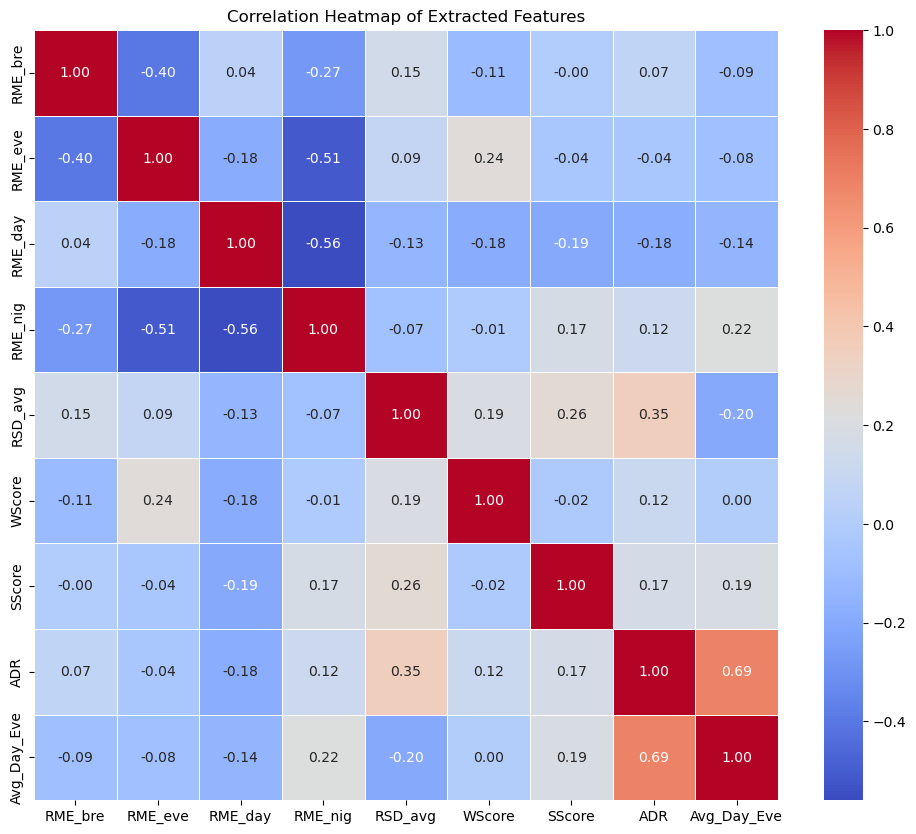

In [39]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.mixture import GaussianMixture

# 1. Prepare the Data for Clustering
features = ['RME_bre', 'RME_eve', 'RME_day', 'RME_nig', 'RSD_avg', 'WScore','SScore', 'ADR', 'Avg_Day_Eve']
X = df100_features[features]
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Plot the Correlation Heatmap of Extracted Features
plt.figure(figsize=(12, 10))
corr = df100_features[features].corr()
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Correlation Heatmap of Extracted Features')
plt.show()

This next correlation heatmap includes categorical features


Lets filter only UKI (London) to get the weather out of the ecuation.

## Section 2.3 Hierarchical Clustering on features

Hierarchical Clustering with Dendrograms.



### Section 2.3.1 Hierarchical Clustering with Complete

Using method = 'complete' in linkage to be robust against outliners.

      ANON_ID  Cluster_HC
0           3           4
1           5           6
2           7           9
3           8          11
4          10           5
...       ...         ...
4723    16240           2
4724    16242           4
4725    16244           2
4726    16247           6
4727    16248           1

[4728 rows x 2 columns]
    Cluster_HC  Count
0            1    629
1            2    747
2            3    346
3            4    854
4            5    299
5            6    230
6            7    106
7            8     76
8            9    304
9           10     63
10          11    560
11          12    143
12          13    371


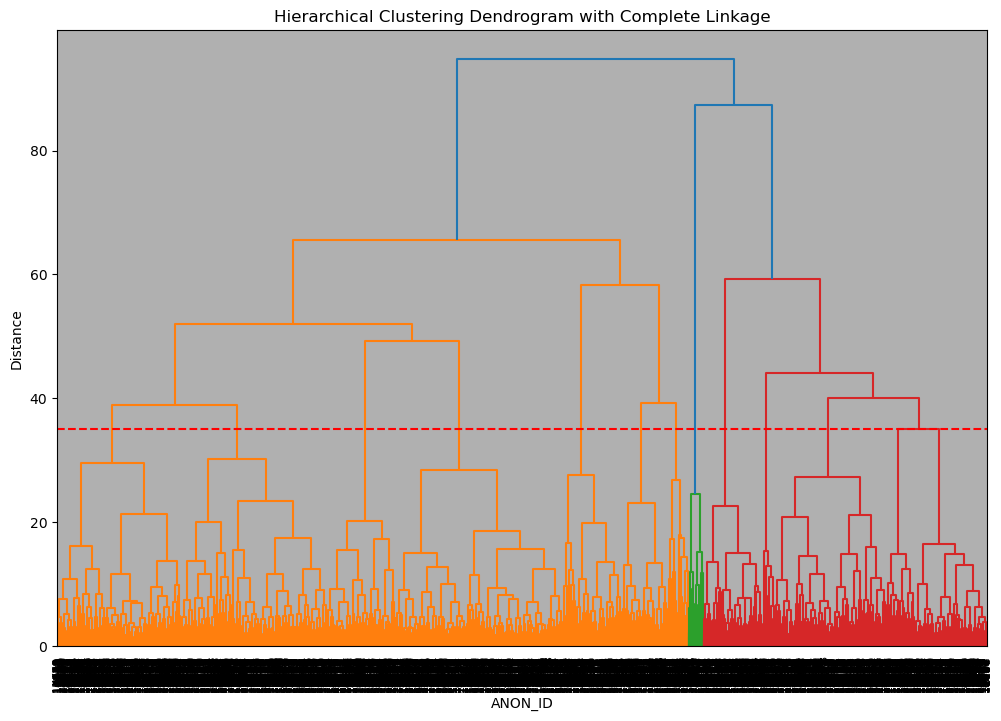

In [24]:
import pandas as pd
from scipy.cluster.hierarchy import linkage, fcluster

# Assuming you have already standardized the data and performed hierarchical clustering
# features = ['RME_bre', 'RME_eve', 'RME_day', 'RME_nig', 'RSD_avg', 'SScore', 'WScore']
# X_scaled is the standardized dataset

# Perform hierarchical clustering with complete linkage
linked = linkage(X_scaled, method='ward')

# Set the distance threshold and obtain cluster labels
distance_threshold = 35
cluster_labels = fcluster(linked, t=distance_threshold, criterion='distance')

# Add the cluster labels to the df100_features DataFrame
df100_features['Cluster_HC'] = cluster_labels

# Create a table with ANON_IDs and their assigned hierarchical cluster labels
cluster_table = df100_features[['ANON_ID', 'Cluster_HC']]

# Display the resulting table
print(cluster_table)


# Count the number of ANON_IDs per cluster
cluster_counts = df100_features['Cluster_HC'].value_counts().reset_index()
cluster_counts.columns = ['Cluster_HC', 'Count']

# Sort the clusters by Cluster_HC for better readability
cluster_counts = cluster_counts.sort_values(by='Cluster_HC').reset_index(drop=True)

# Display the resulting count table
print(cluster_counts)

import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import dendrogram

plt.figure(figsize=(12, 8))
dendrogram(linked, labels=df100_features['ANON_ID'].values, leaf_rotation=90, leaf_font_size=8)
plt.axhline(y=distance_threshold, color='r', linestyle='--')  # Add a horizontal cut line at distance = 7
plt.title('Hierarchical Clustering Dendrogram with Complete Linkage')
plt.xlabel('ANON_ID')
plt.ylabel('Distance')
plt.grid(True)
plt.show()



### Section 2.3.2 Remove the clusters that include only more than 30 ANON_IDs

Hierarchical Clustering with Dendrograms.

Using method = 'ward' in linkage to minimize variance

In [25]:
# Step 1: Identify clusters with less than 15 ANON_IDs
clusters_to_drop = cluster_counts[cluster_counts['Count'] < 20]['Cluster_HC'].tolist()
print(f"Clusters to be dropped: {clusters_to_drop}")

# Step 2: Identify ANON_IDs in those clusters
anon_ids_to_drop = df100_features[df100_features['Cluster_HC'].isin(clusters_to_drop)]['ANON_ID'].tolist()

# Step 3: Filter df100_features to exclude these ANON_IDs
df100selected = df100_features[~df100_features['ANON_ID'].isin(anon_ids_to_drop)].copy()

# Reset the index of df100selected
df100selected.reset_index(drop=True, inplace=True)

# Display information about the filtered DataFrame
print(f"Initial count of ANON_IDs: {len(df100_features['ANON_ID'])}")
print(f"Final count of ANON_IDs: {len(df100selected['ANON_ID'])}")
print(df100selected) 



Clusters to be dropped: []
Initial count of ANON_IDs: 4728
Final count of ANON_IDs: 4728
      ANON_ID   RME_bre   RME_day   RME_eve   RME_nig    SScore    WScore  \
0           3  1.016894  0.997561  1.310435  0.744007 -0.176808 -0.053613   
1           5  1.561702  1.006424  1.310253  0.408458  0.084449  0.136238   
2           7  0.852693  0.728776  1.899032  0.586137  0.368460  0.384740   
3           8  1.304004  0.884724  1.532926  0.483151  0.156239  0.238906   
4          10  0.813098  0.970251  1.906463  0.409217  1.730239 -0.027374   
...       ...       ...       ...       ...       ...       ...       ...   
4723    16240  1.105578  1.125335  1.556399  0.390474  0.122849  0.015024   
4724    16242  0.809831  1.198649  1.354707  0.671327  0.107356 -0.069638   
4725    16244  1.238700  1.000070  1.515865  0.444032  0.511446 -0.172709   
4726    16247  1.425441  1.158541  1.290142  0.362275  0.248480 -0.180068   
4727    16248  0.572670  0.861570  1.761162  0.759347  0.178853 

### Section 2.3.3 Perform Hierarchical clustering with XXXX method

Hierarchical Clustering with Dendrograms.

Using method = 'ward' in linkage

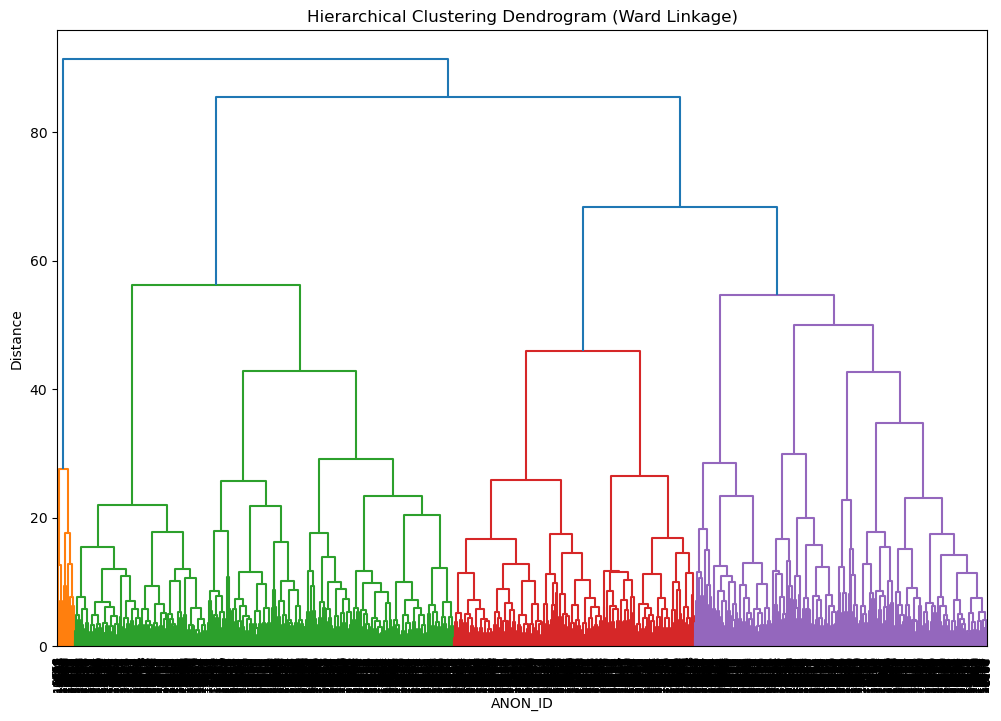

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import linkage, dendrogram
from sklearn.preprocessing import StandardScaler

# 1. Prepare the Data for Clustering
features = ['RME_bre', 'RME_eve', 'RME_day', 'RME_nig', 'RSD_avg', 'WScore', 'SScore', 'ADR', 'Avg_Day_Eve']
X = df100_features[features]
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Ensure labels are aligned
labels = df100_features['ANON_ID'].values

# Step 3: Perform Hierarchical Clustering using Ward Linkage
linked = linkage(X_scaled, method='ward', metric="euclidean")

# Step 4: Plot the Dendrogram
plt.figure(figsize=(12, 8))
dendrogram(
    linked,
    labels=labels,
    leaf_rotation=90,
    leaf_font_size=8
)
plt.title('Hierarchical Clustering Dendrogram (Ward Linkage)')
plt.xlabel('ANON_ID')
plt.ylabel('Distance')
plt.show()

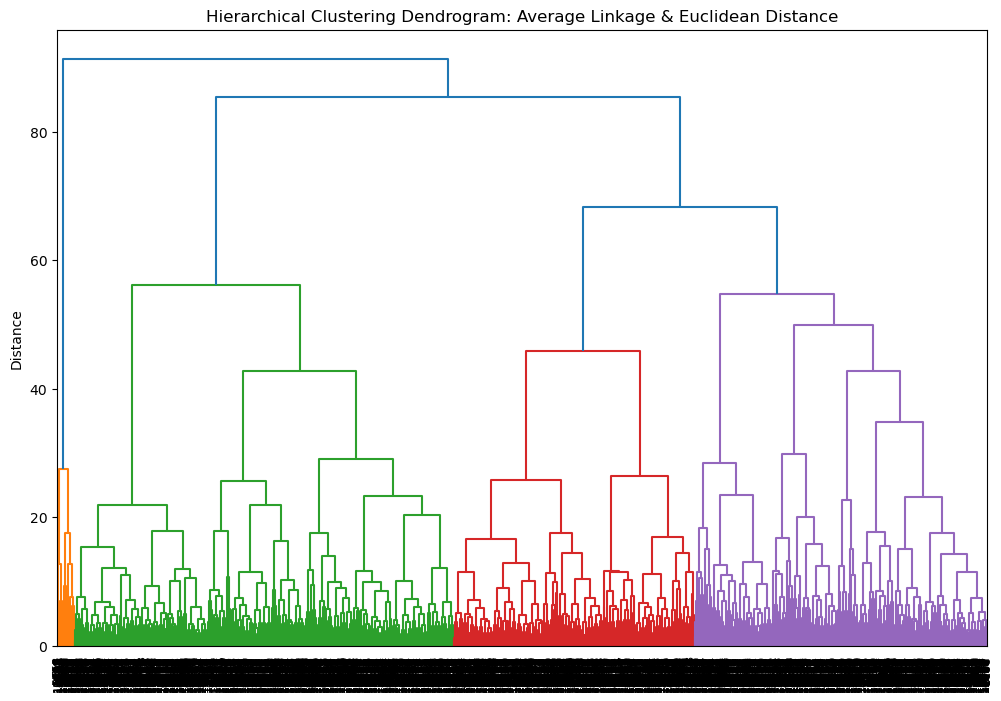

In [ ]:
features = ['RME_bre', 'RME_eve', 'RME_day', 'RME_nig', 'RSD_avg', 'WScore', 'SScore', 'ADR', 'Avg_Day_Eve']
X = df100_features[features]
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Ensure labels are aligned
labels = df100_features['ANON_ID'].values

# Step 3: Perform Hierarchical Clustering using Ward Linkage
linked = linkage(X_scaled, method='ward', metric="euclidean")

# Step 4: Plot the Dendrogram
plt.figure(figsize=(12, 8))
dendrogram(
    linked,
    labels=labels,
    leaf_rotation=90,
    leaf_font_size=8
)
plt.title('Hierarchical Clustering Dendrogram: Average Linkage & Euclidean Distance')
plt.ylabel('Distance')
plt.show()

In [ ]:
from scipy.cluster.hierarchy import cophenet
from scipy.spatial.distance import pdist

features = ['RME_bre', 'RME_eve', 'RME_day', 'RME_nig', 'RSD_avg', 'WScore', 'SScore', 'ADR', 'Avg_Day_Eve']
X = df100_features[features]
X_scaled = StandardScaler().fit_transform(X)

methods = ['average', 'complete', 'single']
metrics = ['euclidean', 'correlation', 'chebyshev', 'cityblock']
xs = [X, X_scaled]

for method in methods:
    for i in xs:
        for metric in metrics:
            linked = linkage(i, method=method, metric=metric)
            coph_dist, coph_dendro = cophenet(linked, pdist(i))
            print(method + " " + metric + " " + f"Cophenetic Correlation Coefficient: {coph_dist}")
    

linked = linkage(X_scaled, method='ward', metric="euclidean")
coph_dist, coph_dendro = cophenet(linked, pdist(X_scaled))
print("ward" + " " + "euclidean" + " " + f"Cophenetic Correlation Coefficient: {coph_dist}")

linked = linkage(X_scaled, method='median', metric="euclidean")
coph_dist, coph_dendro = cophenet(linked, pdist(X_scaled))
print("median" + " " + "euclidean" + " " + f"Cophenetic Correlation Coefficient: {coph_dist}")



# You can plot the correlation for different numbers of clusters
#print(f"Cophenetic Correlation Coefficient: {coph_dist}")


average euclidean Cophenetic Correlation Coefficient: 0.8171702591875095
average correlation Cophenetic Correlation Coefficient: 0.6704189308175659
average chebyshev Cophenetic Correlation Coefficient: 0.7925899128489896
average cityblock Cophenetic Correlation Coefficient: 0.8075822619232051
average euclidean Cophenetic Correlation Coefficient: 0.8059368217919813
average correlation Cophenetic Correlation Coefficient: 0.25139521428883305
average chebyshev Cophenetic Correlation Coefficient: 0.8019950072880571
average cityblock Cophenetic Correlation Coefficient: 0.7781822645817771
complete euclidean Cophenetic Correlation Coefficient: 0.6055229491803306
complete correlation Cophenetic Correlation Coefficient: 0.4718874246298732
complete chebyshev Cophenetic Correlation Coefficient: 0.574321818928328
complete cityblock Cophenetic Correlation Coefficient: 0.5939324329620344
complete euclidean Cophenetic Correlation Coefficient: 0.549248771754476
complete correlation Cophenetic Correlati

In [ ]:
from scipy.cluster.hierarchy import linkage, fcluster

features = ['RME_bre', 'RME_eve', 'RME_day', 'RME_nig', 'RSD_avg', 'WScore', 'SScore', 'ADR', 'Avg_Day_Eve']
X = df100_features[features]
X_scaled = StandardScaler().fit_transform(X)
linked = linkage(X_scaled, method='ward', metric="euclidean")
cluster_labels = fcluster(linked, t=35, criterion='distance')

df100_features['Cluster'] = cluster_labels

# Create a table with ANON_IDs and their assigned hierarchical cluster labels
cluster_table = df100_features[['ANON_ID', 'Cluster']]

cluster_counts = df100_features['Cluster'].value_counts().reset_index()
cluster_counts.columns = ['Cluster', 'Count']

# Sort the clusters by Cluster_HC for better readability
cluster_counts = cluster_counts.sort_values(by='Cluster').reset_index(drop=True)
print(cluster_counts)


   Cluster  Count
0        1     82
1        2    610
2        3    448
3        4    685
4        5    686
5        6    422
6        7    356
7        8    302
8        9     95
9       10    590


In [ ]:

# Merge cluster information back into the original data (if not already included)
df_with_clusters = df100.merge(
    df100_features[['ANON_ID', 'Cluster']],
    on='ANON_ID',
    how='inner'
)

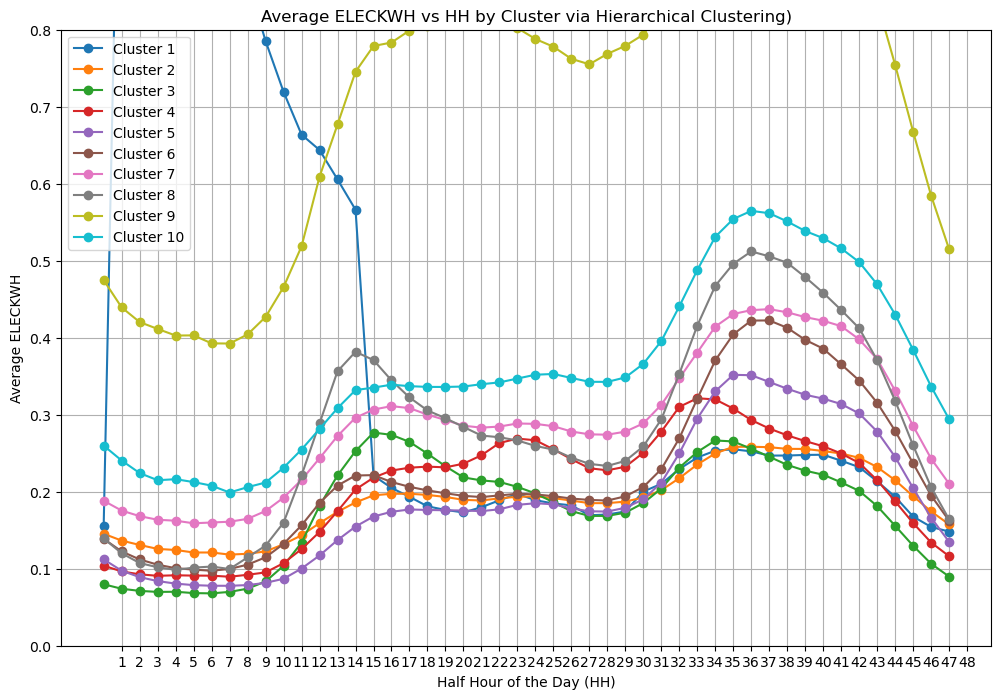

In [ ]:
import matplotlib.pyplot as plt
# Group by Cluster and HH, and calculate the mean ELECKWH
clustered_means_reduced = df_with_clusters.groupby(['Cluster', 'HH'])['ELECKWH'].mean().reset_index()
plt.figure(figsize=(12, 8))

# Plot each cluster
for cluster in clustered_means_reduced['Cluster'].unique():
    cluster_data_reduced = clustered_means_reduced[clustered_means_reduced['Cluster'] == cluster]
    plt.plot(cluster_data_reduced['HH'], cluster_data_reduced['ELECKWH'], label=f'Cluster {cluster}', marker='o')

# Plot details
plt.title('Average ELECKWH vs HH by Cluster via Hierarchical Clustering)')
plt.xlabel('Half Hour of the Day (HH)')
plt.ylabel('Average ELECKWH')
plt.xticks(range(1, 49))  # HH typically ranges from 1 to 48
plt.legend()
plt.ylim(0,0.8)
plt.grid(True)
plt.show()

## Method 2: GMM with AIC, BIC, and Silhouette Score as Evaluation Metricsto define the optimal amount of clusters


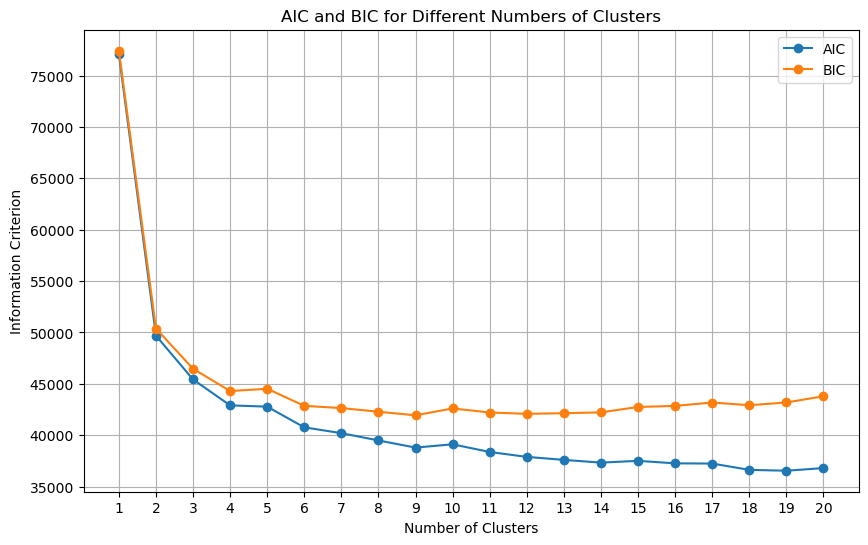

In [15]:
import os
os.environ["OMP_NUM_THREADS"] = "7"  # Adjust the number of threads if needed
 # Because Not gonna drop any ID
# Then proceed with your imports and KMeans code
from sklearn.cluster import KMeans
import numpy as np
import matplotlib.pyplot as plt
from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import StandardScaler

# 1. Prepare the Data for Clustering
features = ['RME_bre', 'RME_eve', 'RME_day', 'RME_nig', 'RSD_avg', 'WScore', 'SScore', 'ADR', 'Avg_Day_Eve']
X = df100_features[features]
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Define the range for the number of clusters
cluster_range = range(1, 21)

# Lists to store AIC and BIC values
aic_values = []
bic_values = []

# Fit GMM models and calculate AIC and BIC for each number of clusters
for n_clusters in cluster_range:
    gmm = GaussianMixture(n_components=n_clusters, random_state=498)
    gmm.fit(X_scaled)
    aic_values.append(gmm.aic(X_scaled))
    bic_values.append(gmm.bic(X_scaled))


# Plot the AIC and BIC values
plt.figure(figsize=(10, 6))
plt.plot(cluster_range, aic_values, marker='o', label='AIC')
plt.plot(cluster_range, bic_values, marker='o', label='BIC')
plt.xlabel('Number of Clusters')
plt.ylabel('Information Criterion')
plt.title('AIC and BIC for Different Numbers of Clusters')
plt.xticks(cluster_range)
plt.legend()
plt.grid(True)
plt.show()


Number of Clusters: 2, Silhouette Score: 0.28118138477202986
Number of Clusters: 3, Silhouette Score: 0.09871377865675722
Number of Clusters: 4, Silhouette Score: 0.07905027526814482
Number of Clusters: 5, Silhouette Score: 0.025822659168733903
Number of Clusters: 6, Silhouette Score: 0.011849045009629418
Number of Clusters: 7, Silhouette Score: 0.014380076150025243
Number of Clusters: 8, Silhouette Score: 0.021192143073236917
Number of Clusters: 9, Silhouette Score: 0.007379625789385282
Number of Clusters: 10, Silhouette Score: -0.015098162999946946
Number of Clusters: 11, Silhouette Score: -0.010052576331243158
Number of Clusters: 12, Silhouette Score: -0.009629607063697245
Number of Clusters: 13, Silhouette Score: -0.01053139308285367
Number of Clusters: 14, Silhouette Score: -0.010846026624510268
Number of Clusters: 15, Silhouette Score: -0.03286916715888571
Number of Clusters: 16, Silhouette Score: -0.026119634248120267
Number of Clusters: 17, Silhouette Score: -0.0309473070228874

Number of Clusters  Silhouette Score
0                    2          0.281181
1                    3          0.098714
2                    4          0.079050
3                    5          0.025823
4                    6          0.011849
5                    7          0.014380
6                    8          0.021192
7                    9          0.007380
8                   10         -0.015098
9                   11         -0.010053
10                  12         -0.009630
11                  13         -0.010531
12                  14         -0.010846
13                  15         -0.032869
14                  16         -0.026120
15                  17         -0.030947
16                  18         -0.027580
17                  19         -0.052952
18                  20         -0.032888

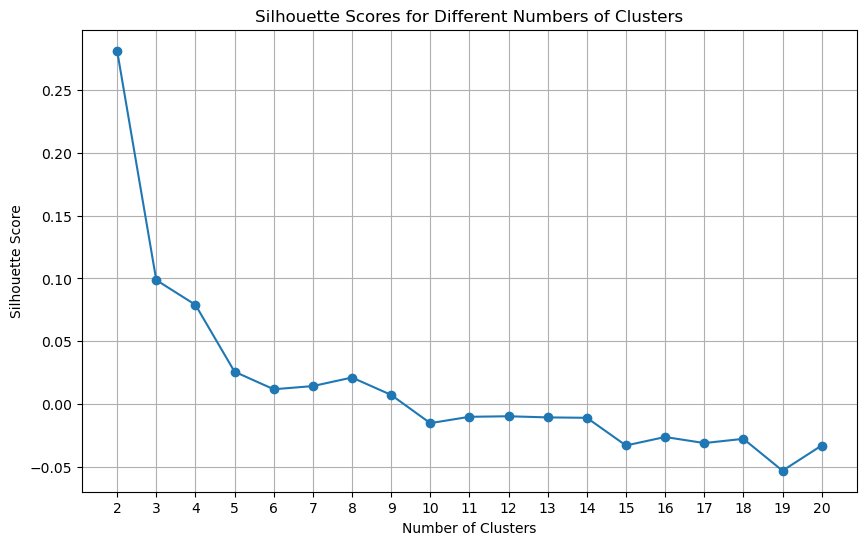

In [16]:
import os
os.environ["OMP_NUM_THREADS"] = "7"  # Adjust the number of threads if needed
from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
import pandas as pd

# Prepare the Data for Clustering
features = ['RME_bre', 'RME_eve', 'RME_day', 'RME_nig', 'RSD_avg', 'WScore', 'SScore', 'ADR', 'Avg_Day_Eve']
X = df100_features[features]
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Define the range for the number of clusters
cluster_range = range(2, 21)  # Start with 2 clusters (minimum valid for silhouette score)

# Initialize a list to store results
results = []

# Loop through each number of clusters
for n_clusters in cluster_range:
    # Fit the GMM model
    gmm = GaussianMixture(n_components=n_clusters, random_state=42)
    cluster_labels = gmm.fit_predict(X_scaled)
    
    # Calculate the silhouette score
    silhouette_avg = silhouette_score(X_scaled, cluster_labels)
    
    # Append the results
    results.append({'Number of Clusters': n_clusters, 'Silhouette Score': silhouette_avg})

    print(f"Number of Clusters: {n_clusters}, Silhouette Score: {silhouette_avg}")

# Convert results to a DataFrame
results_df = pd.DataFrame(results)

# Display the results as a table
display(results_df)

# Plot the results
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
plt.plot(results_df['Number of Clusters'], results_df['Silhouette Score'], marker='o')
plt.title('Silhouette Scores for Different Numbers of Clusters')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.xticks(cluster_range)
plt.grid(True)
plt.show()



Testing Gaussianity for feature: RME_bre
Shapiro-Wilk: {'Statistic': 0.9463181469413644, 'p-value': 6.55861592903361e-37}
Kolmogorov-Smirnov: {'Statistic': 0.07304289302924627, 'p-value': 2.76494323986762e-20}
Anderson-Darling: {'Statistic': 39.92057832696992, 'Critical Values': array([0.575, 0.655, 0.786, 0.917, 1.091])}

Testing Gaussianity for feature: RME_eve
Shapiro-Wilk: {'Statistic': 0.9768420762371056, 'p-value': 7.940537532301952e-26}
Kolmogorov-Smirnov: {'Statistic': 0.032803288945866205, 'p-value': 0.00019688696624404646}
Anderson-Darling: {'Statistic': 11.129354270919976, 'Critical Values': array([0.575, 0.655, 0.786, 0.917, 1.091])}

Testing Gaussianity for feature: RME_day
Shapiro-Wilk: {'Statistic': 0.9749449196882535, 'p-value': 8.912659365541778e-27}
Kolmogorov-Smirnov: {'Statistic': 0.04629388515503097, 'p-value': 2.1110071662367256e-08}
Anderson-Darling: {'Statistic': 22.970611461889348, 'Critical Values': array([0.575, 0.655, 0.786, 0.917, 1.091])}

Testing Gaussia

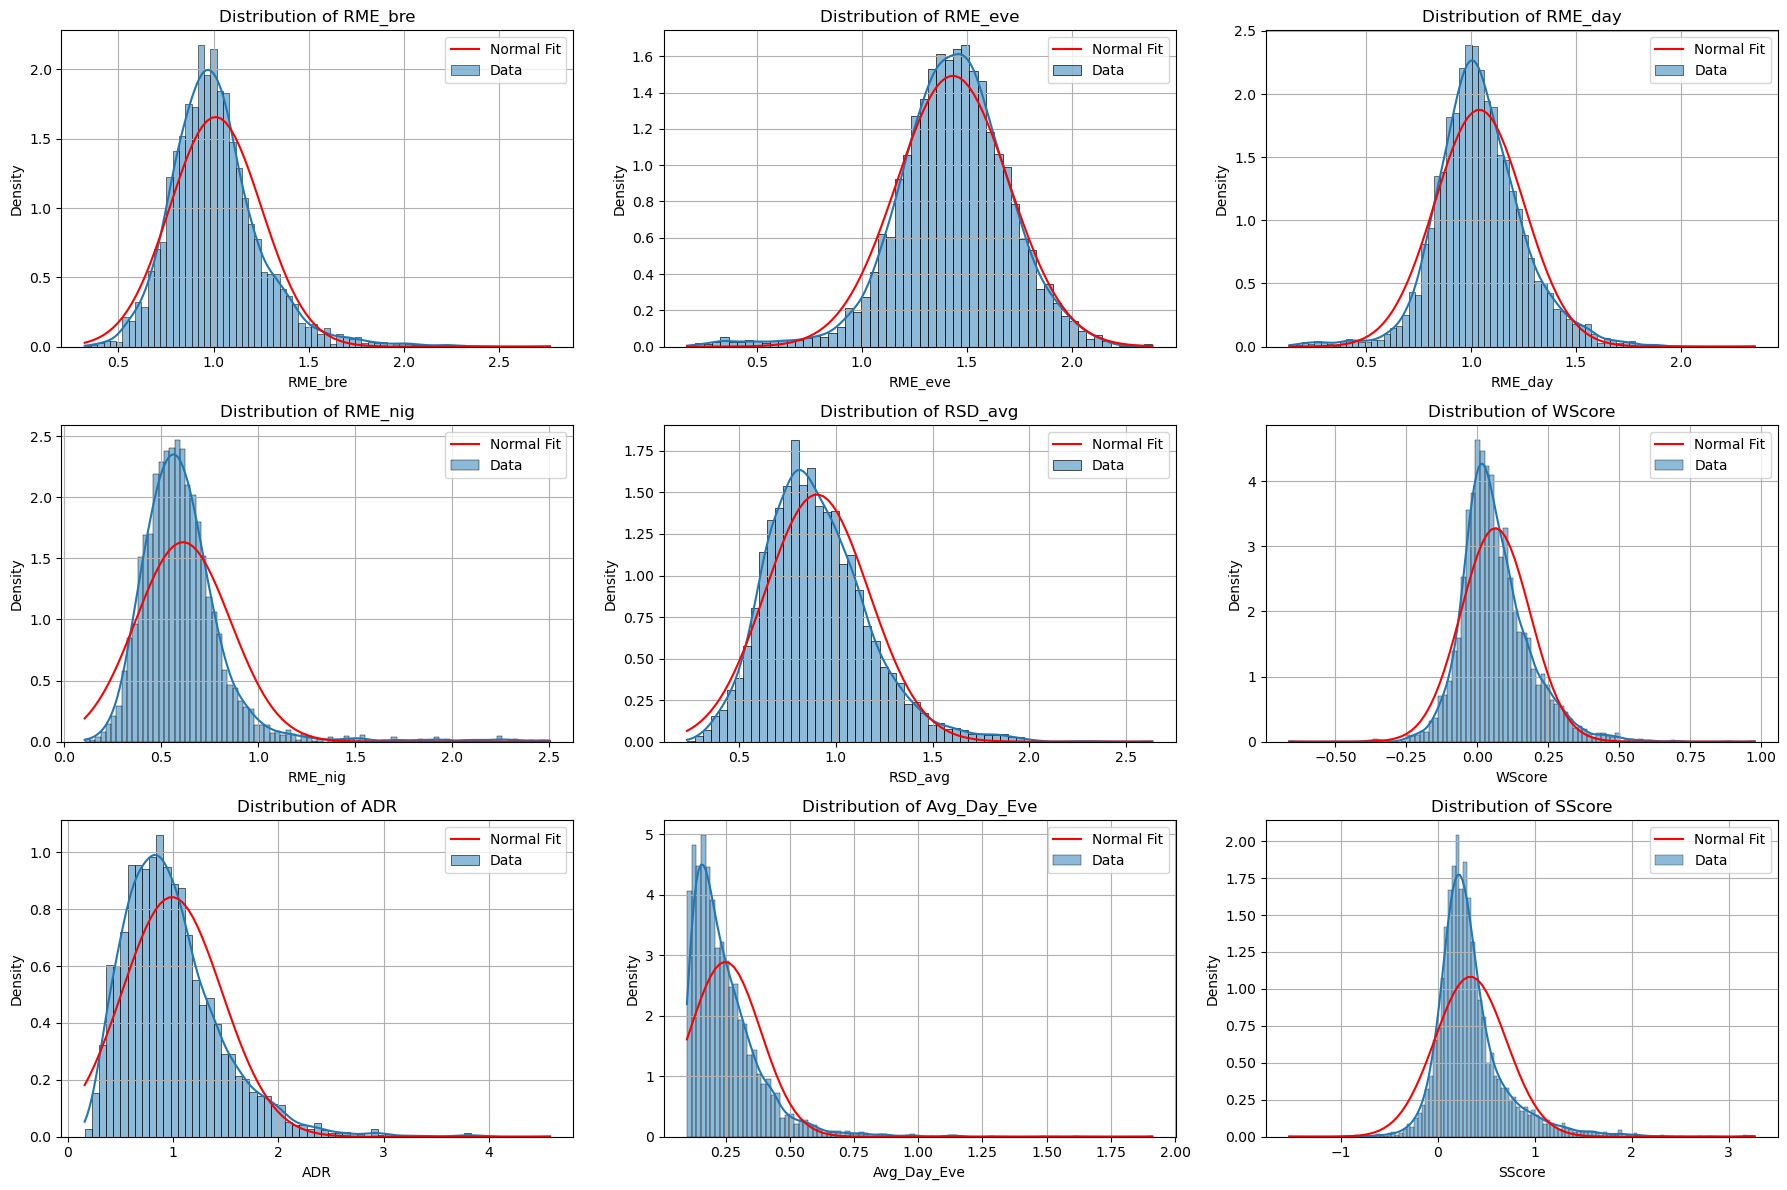

In [52]:
import pandas as pd
import numpy as np
from scipy.stats import shapiro, kstest, anderson
import matplotlib.pyplot as plt
import seaborn as sns
df100selected_features = df100_features
# Updated list of features
features = ['RME_bre', 'RME_eve', 'RME_day', 'RME_nig', 'RSD_avg', 'WScore', 'ADR', 'Avg_Day_Eve','SScore']

# Example DataFrame (replace with your actual DataFrame)
X = df100selected_features[features]

# Function to test Gaussianity
def test_gaussianity(feature_data):
    results = {}

    # Shapiro-Wilk Test
    shapiro_stat, shapiro_p = shapiro(feature_data)
    results['Shapiro-Wilk'] = {'Statistic': shapiro_stat, 'p-value': shapiro_p}

    # Kolmogorov-Smirnov Test
    ks_stat, ks_p = kstest(feature_data, 'norm', args=(feature_data.mean(), feature_data.std()))
    results['Kolmogorov-Smirnov'] = {'Statistic': ks_stat, 'p-value': ks_p}

    # Anderson-Darling Test
    anderson_result = anderson(feature_data)
    results['Anderson-Darling'] = {'Statistic': anderson_result.statistic, 'Critical Values': anderson_result.critical_values}

    return results

# Adjust grid layout based on the number of features
num_features = len(features)
rows = (num_features + 2) // 3  # Calculate number of rows for a 3-column layout
fig, axes = plt.subplots(rows, 3, figsize=(18, rows * 4))
axes = axes.flatten()

for i, feature in enumerate(features):
    # Drop NaN values for the feature
    feature_data = X[feature].dropna()

    # Run Gaussianity tests
    results = test_gaussianity(feature_data)
    print(f"\nTesting Gaussianity for feature: {feature}\n{'=' * 40}")
    for test_name, result in results.items():
        print(f"{test_name}: {result}")
    
    # Plot histogram with KDE and Q-Q plot
    ax = axes[i]
    sns.histplot(feature_data, kde=True, stat="density", label="Data", ax=ax)
    x = np.linspace(feature_data.min(), feature_data.max(), 100)
    normal_curve = np.exp(-0.5 * ((x - feature_data.mean()) / feature_data.std())**2) / (feature_data.std() * np.sqrt(2 * np.pi))
    ax.plot(x, normal_curve, label="Normal Fit", color='red')
    ax.set_title(f"Distribution of {feature}")
    ax.set_xlabel(feature)
    ax.set_ylabel("Density")
    ax.legend()
    ax.grid()

# Remove any unused axes (in case of extra grid spaces)
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

# Notes on Gaussianity:
# Anderson-Darling Normality test: For datasets smaller than 500 entries, 
# the feature follows a normal distribution when the statistic is less than 0.6.


### Section 2.3.5 Get table with count of ANON_ID per cluster

Now that I identified that 6 is the optimal number of clusters, lets fit the GMM and see how many IDs per cluster, and their attributes

# FIT THE MODEL WITH SOME FEATURES

In [25]:
from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import StandardScaler
import pandas as pd

# Define the reduced set of features for clustering
features = ['RME_bre', 'RME_eve', 'RME_day', 'RME_nig', 'RSD_avg', 'WScore', 'ADR', 'Avg_Day_Eve','SScore']
# df100selected_features_reduced = df100selected

# Prepare the data for clustering
X = df100_features[features]

# Scale the data
X_scaled = StandardScaler().fit_transform(X)

# Fit the Gaussian Mixture Model
gmm_reduced = GaussianMixture(n_components=10, random_state=42)
df100_features['Cluster'] = gmm_reduced.fit_predict(X_scaled)

# Count the number of consumers per cluster
cluster_counts_reduced = df100_features['Cluster'].value_counts().reset_index()
cluster_counts_reduced.columns = ['Cluster', 'Number_of_Consumers']

# Sort the clusters for better readability
cluster_counts_reduced = cluster_counts_reduced.sort_values(by='Cluster').reset_index(drop=True)

# Display the cluster counts
print(cluster_counts_reduced)


   Cluster  Number_of_Consumers
0        0                  159
1        1                  106
2        2                  773
3        3                   20
4        4                 1011
5        5                   78
6        6                  289
7        7                  169
8        8                  703
9        9                  968


In [18]:
# Define attributes for cluster analysis (reduced set)
selected_attributes_reduced = ['RME_bre', 'RME_eve', 'RME_day', 'RME_nig', 'Avg_Day_Eve']

# Group by Cluster and calculate the mean for each attribute
cluster_means_reduced = df100_features.groupby('Cluster')[selected_attributes_reduced].mean().reset_index()

# Round to 2 decimal places
cluster_means_reduced = cluster_means_reduced.round(2)

# Apply color scale using Pandas Styler
def apply_color_scale_reduced(df):
    return df.style.background_gradient(cmap="coolwarm", axis=0).format(precision=2)

# Apply the color scale to the DataFrame
styled_cluster_means_reduced = apply_color_scale_reduced(cluster_means_reduced)

# Display the styled DataFrame
styled_cluster_means_reduced


In [19]:

# Ensure 'HH' and 'ELECKWH' columns are in the dataframe
if 'HH' not in df100.columns or 'ELECKWH' not in df100.columns:
    raise KeyError("The dataframe must contain 'HH' and 'ELECKWH' columns.")

# Merge cluster information back into the original data (if not already included)
df_with_clusters_reduced = df100.merge(
    df100_features[['ANON_ID', 'Cluster']],
    on='ANON_ID',
    how='inner'
)


In [27]:
display(df_with_clusters)

NameError: name 'df_with_clusters' is not defined

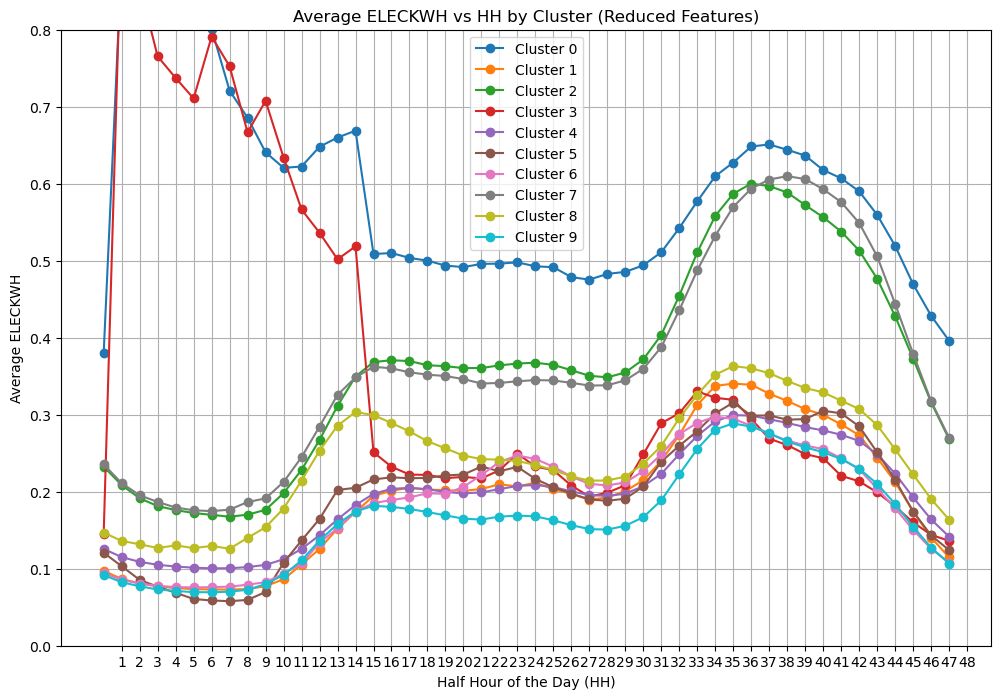

In [20]:
import matplotlib.pyplot as plt

# Group by Cluster and HH, and calculate the mean ELECKWH
clustered_means_reduced = df_with_clusters_reduced.groupby(['Cluster', 'HH'])['ELECKWH'].mean().reset_index()

# Plot each cluster
plt.figure(figsize=(12, 8))
for cluster in clustered_means_reduced['Cluster'].unique():
    cluster_data_reduced = clustered_means_reduced[clustered_means_reduced['Cluster'] == cluster]
    plt.plot(cluster_data_reduced['HH'], cluster_data_reduced['ELECKWH'], label=f'Cluster {cluster}', marker='o')

# Plot details
plt.title('Average ELECKWH vs HH by Cluster (Reduced Features)')
plt.xlabel('Half Hour of the Day (HH)')
plt.ylabel('Average ELECKWH')
plt.xticks(range(1, 49))  # HH typically ranges from 1 to 48
plt.legend()
plt.ylim(0,0.8)
plt.grid(True)
plt.show()

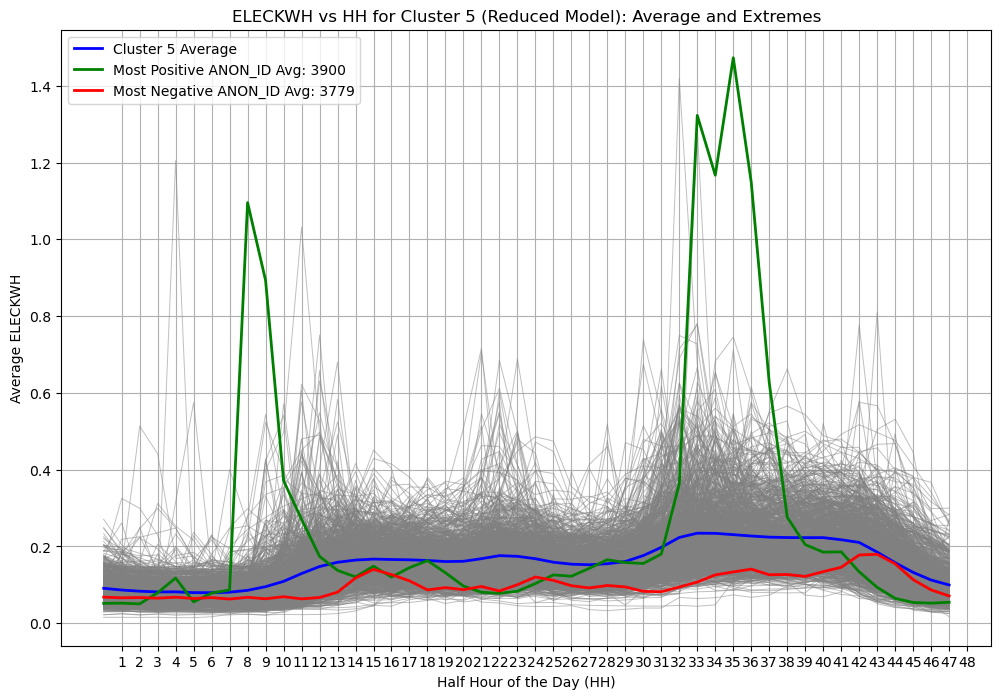

Features Table for Cluster 5 and Selected ANON_IDs:
                  RME_bre   RME_eve   RME_day   RME_nig  Avg_Day_Eve
ANON_ID                                                             
Cluster_Average  1.292373  1.418103  0.978790  0.507939     0.174224
3900             0.498613  2.078043  0.531759  0.812991     0.276019
3779             1.010500  1.394348  0.961233  0.708860     0.100196


In [ ]:
import matplotlib.pyplot as plt

# Filter the data for Cluster 5 in the reduced model
cluster_5_data_reduced = df_with_clusters_reduced[df_with_clusters_reduced['Cluster'] == 6]

# Calculate the average ELECKWH per HH for each ANON_ID in Cluster 5
cluster_5_avg_by_anon_reduced = (
    cluster_5_data_reduced.groupby(['ANON_ID', 'HH'])['ELECKWH']
    .mean()
    .reset_index()
)

# Calculate the cluster average ELECKWH per HH
cluster_5_avg_reduced = (
    cluster_5_avg_by_anon_reduced.groupby('HH')['ELECKWH']
    .mean()
    .reset_index()
    .rename(columns={'ELECKWH': 'Cluster_Avg_ELECKWH'})
)

# Merge the cluster average back with the individual ANON_ID data
cluster_5_data_reduced = cluster_5_data_reduced.merge(cluster_5_avg_reduced, on='HH', how='left')

# Calculate the absolute difference from the cluster average for each ANON_ID
cluster_5_data_reduced['Difference'] = cluster_5_data_reduced['ELECKWH'] - cluster_5_data_reduced['Cluster_Avg_ELECKWH']

# Calculate the mean difference per ANON_ID
anon_diff_reduced = (
    cluster_5_data_reduced.groupby('ANON_ID')['Difference']
    .mean()
    .reset_index()
    .rename(columns={'Difference': 'Mean_Difference'})
)

# Identify the ANON_IDs with the most positive and most negative differences
most_positive_anon_reduced = anon_diff_reduced.loc[anon_diff_reduced['Mean_Difference'].idxmax(), 'ANON_ID']
most_negative_anon_reduced = anon_diff_reduced.loc[anon_diff_reduced['Mean_Difference'].idxmin(), 'ANON_ID']

# Extract data for the identified ANON_IDs
positive_anon_data_reduced = (
    cluster_5_avg_by_anon_reduced[cluster_5_avg_by_anon_reduced['ANON_ID'] == most_positive_anon_reduced]
    .groupby('HH')['ELECKWH']
    .mean()
    .reset_index()
)

negative_anon_data_reduced = (
    cluster_5_avg_by_anon_reduced[cluster_5_avg_by_anon_reduced['ANON_ID'] == most_negative_anon_reduced]
    .groupby('HH')['ELECKWH']
    .mean()
    .reset_index()
)

# Plot the data
plt.figure(figsize=(12, 8))

# Plot all ANON_IDs in grey
for anon_id in cluster_5_avg_by_anon_reduced['ANON_ID'].unique():
    anon_data = cluster_5_avg_by_anon_reduced[cluster_5_avg_by_anon_reduced['ANON_ID'] == anon_id]
    plt.plot(anon_data['HH'], anon_data['ELECKWH'], color='grey', alpha=0.5, linewidth=0.7)

# Plot the cluster average in blue
plt.plot(
    cluster_5_avg_reduced['HH'], cluster_5_avg_reduced['Cluster_Avg_ELECKWH'],
    color='blue', linewidth=2, label='Cluster 5 Average'
)

# Plot the most positive ANON_ID in green
plt.plot(
    positive_anon_data_reduced['HH'], positive_anon_data_reduced['ELECKWH'],
    color='green', linewidth=2, label=f'Most Positive ANON_ID Avg: {most_positive_anon_reduced}'
)

# Plot the most negative ANON_ID in red
plt.plot(
    negative_anon_data_reduced['HH'], negative_anon_data_reduced['ELECKWH'],
    color='red', linewidth=2, label=f'Most Negative ANON_ID Avg: {most_negative_anon_reduced}'
)

# Plot details
plt.title('ELECKWH vs HH for Cluster 5 (Reduced Model): Average and Extremes')
plt.xlabel('Half Hour of the Day (HH)')
plt.ylabel('Average ELECKWH')
plt.xticks(range(1, 49))  # HH typically ranges from 1 to 48
plt.legend()
plt.grid(True)
plt.show()



# Prepare a DataFrame to store the features for the cluster and selected ANON_IDs
table_data = {}

# Add cluster-wide average features
table_data['Cluster_Average'] = (
    df100selected_features_reduced[df100selected_features_reduced['Cluster'] == 5][features_reduced]
    .mean()
    .to_dict()
)

# Add features for the most positive ANON_ID
table_data[most_positive_anon_reduced] = (
    df100selected_features_reduced[df100selected_features_reduced['ANON_ID'] == most_positive_anon_reduced][features_reduced]
    .mean()
    .to_dict()
)

# Add features for the most negative ANON_ID
table_data[most_negative_anon_reduced] = (
    df100selected_features_reduced[df100selected_features_reduced['ANON_ID'] == most_negative_anon_reduced][features_reduced]
    .mean()
    .to_dict()
)

# Convert the dictionary to a DataFrame
table_df = pd.DataFrame(table_data)

# Transpose the DataFrame to match the desired format
table_df = table_df.T
table_df.index.name = 'ANON_ID'

# Display the resulting table
print("Features Table for Cluster 5 and Selected ANON_IDs:")
print(table_df)




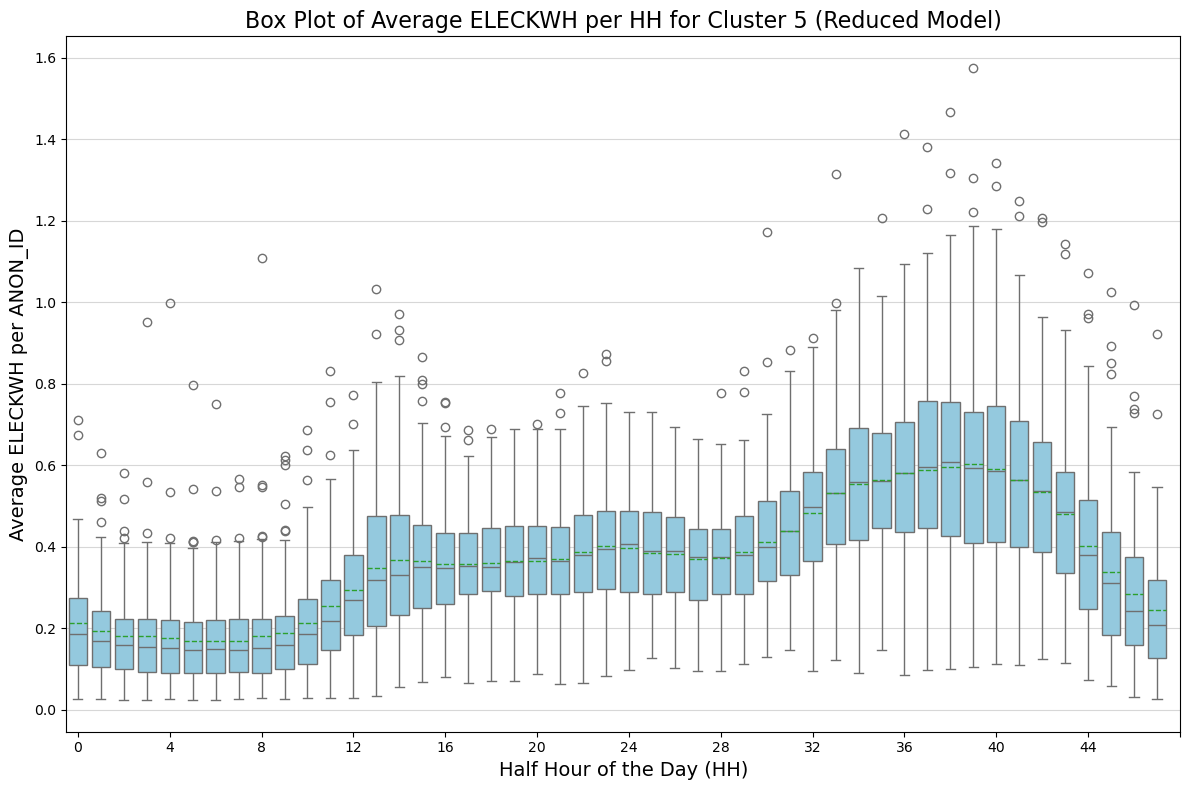

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Filter the data for Cluster 5 in the reduced model
cluster_5_data_reduced = df_with_clusters_reduced[df_with_clusters_reduced['Cluster'] == 8]

# Calculate the average ELECKWH per HH for each ANON_ID
avg_eleckwh_per_hh_anon = (
    cluster_5_data_reduced.groupby(['ANON_ID', 'HH'])['ELECKWH']
    .mean()
    .reset_index()
)

# Plot the box plot for ELECKWH grouped by HH
plt.figure(figsize=(12, 8))
sns.boxplot(data=avg_eleckwh_per_hh_anon, x='HH', y='ELECKWH', color='skyblue', showmeans=True, meanline=True)

# Plot details
plt.title('Box Plot of Average ELECKWH per HH for Cluster YY (Reduced Model)', fontsize=16)
plt.xlabel('Half Hour of the Day (HH)', fontsize=14)
plt.ylabel('Average ELECKWH per ANON_ID', fontsize=14)
plt.xticks(range(0, 49, 4))  # Adjust the ticks for better readability
plt.grid(axis='y', alpha=0.5)
plt.tight_layout()
plt.show()



# FIT THE MODEL WITH SOME FEATURES + RSD

In [17]:
from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import StandardScaler
import pandas as pd

# Define the reduced set of features for clustering
features = ['RME_bre', 'RME_eve', 'RME_day', 'RME_nig', 'RSD_avg', 'WScore', 'ADR', 'Avg_Day_Eve','SScore']
df100_features_gmm = df100_features

# Prepare the data for clustering
X = df100_features_gmm[features]

# Scale the data
scaler_reduced = StandardScaler()
X_scaled = scaler_reduced.fit_transform(X)

# Fit the Gaussian Mixture Model
gmm_reduced = GaussianMixture(n_components=12, random_state=42)
df100_features_gmm['Cluster'] = gmm_reduced.fit_predict(X_scaled)

# Count the number of consumers per cluster
cluster_counts_reduced = df100_features_gmm['Cluster'].value_counts().reset_index()
cluster_counts_reduced.columns = ['Cluster', 'Number_of_Consumers']

# Sort the clusters for better readability
cluster_counts_reduced = cluster_counts_reduced.sort_values(by='Cluster').reset_index(drop=True)

# Define attributes for cluster analysis (reduced set)
selected_attributes_reduced = features

# Group by Cluster and calculate the mean for each attribute
cluster_means_reduced_02 = df100_features_gmm.groupby('Cluster')[selected_attributes_reduced].mean().reset_index()

# Round to 2 decimal places
cluster_means_reduced_02 = cluster_means_reduced_02.round(2)

# Merge the cluster counts into the cluster means
cluster_summary_reduced = cluster_means_reduced_02.merge(cluster_counts_reduced, on='Cluster')

# Apply color scale using Pandas Styler
def apply_color_scale_reduced(df):
    # Apply different color scales for features and the count column
    styled = df.style.background_gradient(cmap="coolwarm", subset=selected_attributes_reduced, axis=0)
    styled = styled.background_gradient(cmap="coolwarm", subset=['Number_of_Consumers'], axis=0)
    return styled.format(precision=2)

# Apply the color scale to the DataFrame
styled_cluster_summary_reduced = apply_color_scale_reduced(cluster_summary_reduced)

# Display the styled DataFrame
styled_cluster_summary_reduced


In [ ]:
def optimize_dataframe(df):
    for col in df.select_dtypes(include=['float64']).columns:
        df[col] = pd.to_numeric(df[col], downcast='float')
    for col in df.select_dtypes(include=['int64']).columns:
        df[col] = pd.to_numeric(df[col], downcast='integer')
    return df

# Optimize df100 and other DataFrames
df100 = optimize_dataframe(df100)
# df100selected_features_reduced_02 = optimize_dataframe(df100selected_features_reduced_02)


MemoryError: Unable to allocate 516. MiB for an array with shape (1, 67625475) and data type float64

In [30]:
import matplotlib.pyplot as plt

# Ensure 'HH' and 'ELECKWH' columns are in the dataframe
if 'HH' not in df100.columns or 'ELECKWH' not in df100.columns:
    raise KeyError("The dataframe must contain 'HH' and 'ELECKWH' columns.")

# Merge cluster information back into the original data (if not already included)
df_with_clusters_reduced = df100.merge(
    df100_features_gmm[['ANON_ID', 'Cluster']],
    on='ANON_ID',
    how='inner'
)

# Group by Cluster and HH, and calculate the mean ELECKWH
clustered_means_reduced = df_with_clusters_reduced.groupby(['Cluster', 'HH'])['ELECKWH'].mean().reset_index()

# Plot each cluster
plt.figure(figsize=(12, 8))
for cluster in clustered_means_reduced['Cluster'].unique():
    cluster_data_reduced = clustered_means_reduced[clustered_means_reduced['Cluster'] == cluster]
    plt.plot(cluster_data_reduced['HH'], cluster_data_reduced['ELECKWH'], label=f'Cluster {cluster}', marker='o')

# Plot details
plt.title('Average ELECKWH vs HH by Cluster (Reduced Features)')
plt.xlabel('Half Hour of the Day (HH)')
plt.ylabel('Average ELECKWH')
plt.xticks(range(1, 49))  # HH typically ranges from 1 to 48
plt.legend()
plt.ylim(0,0.8)
plt.grid(True)
plt.show()


: 

: 

In [ ]:
import matplotlib.pyplot as plt
cluster_02 = 4
# Filter the data for Cluster 5 in the reduced model
cluster_5_data_reduced = df_with_clusters_reduced[df_with_clusters_reduced['Cluster'] == cluster_02]

# Calculate the average ELECKWH per HH for each ANON_ID in Cluster 5
cluster_5_avg_by_anon_reduced = (
    cluster_5_data_reduced.groupby(['ANON_ID', 'HH'])['ELECKWH']
    .mean()
    .reset_index()
)

# Calculate the cluster average ELECKWH per HH
cluster_5_avg_reduced = (
    cluster_5_avg_by_anon_reduced.groupby('HH')['ELECKWH']
    .mean()
    .reset_index()
    .rename(columns={'ELECKWH': 'Cluster_Avg_ELECKWH'})
)

# Merge the cluster average back with the individual ANON_ID data
cluster_5_data_reduced = cluster_5_data_reduced.merge(cluster_5_avg_reduced, on='HH', how='left')

# Calculate the absolute difference from the cluster average for each ANON_ID
cluster_5_data_reduced['Difference'] = cluster_5_data_reduced['ELECKWH'] - cluster_5_data_reduced['Cluster_Avg_ELECKWH']

# Calculate the mean difference per ANON_ID
anon_diff_reduced = (
    cluster_5_data_reduced.groupby('ANON_ID')['Difference']
    .mean()
    .reset_index()
    .rename(columns={'Difference': 'Mean_Difference'})
)

# Identify the ANON_IDs with the most positive and most negative differences
most_positive_anon_reduced = anon_diff_reduced.loc[anon_diff_reduced['Mean_Difference'].idxmax(), 'ANON_ID']
most_negative_anon_reduced = anon_diff_reduced.loc[anon_diff_reduced['Mean_Difference'].idxmin(), 'ANON_ID']

# Extract data for the identified ANON_IDs
positive_anon_data_reduced = (
    cluster_5_avg_by_anon_reduced[cluster_5_avg_by_anon_reduced['ANON_ID'] == most_positive_anon_reduced]
    .groupby('HH')['ELECKWH']
    .mean()
    .reset_index()
)

negative_anon_data_reduced = (
    cluster_5_avg_by_anon_reduced[cluster_5_avg_by_anon_reduced['ANON_ID'] == most_negative_anon_reduced]
    .groupby('HH')['ELECKWH']
    .mean()
    .reset_index()
)

# Plot the data
plt.figure(figsize=(12, 8))

# Plot all ANON_IDs in grey
for anon_id in cluster_5_avg_by_anon_reduced['ANON_ID'].unique():
    anon_data = cluster_5_avg_by_anon_reduced[cluster_5_avg_by_anon_reduced['ANON_ID'] == anon_id]
    plt.plot(anon_data['HH'], anon_data['ELECKWH'], color='grey', alpha=0.5, linewidth=0.7)

# Plot the cluster average in blue
plt.plot(
    cluster_5_avg_reduced['HH'], cluster_5_avg_reduced['Cluster_Avg_ELECKWH'],
    color='blue', linewidth=2, label='Cluster YY Average'
)

# Plot the most positive ANON_ID in green
plt.plot(
    positive_anon_data_reduced['HH'], positive_anon_data_reduced['ELECKWH'],
    color='green', linewidth=2, label=f'Most Positive ANON_ID Avg: {most_positive_anon_reduced}'
)

# Plot the most negative ANON_ID in red
plt.plot(
    negative_anon_data_reduced['HH'], negative_anon_data_reduced['ELECKWH'],
    color='red', linewidth=2, label=f'Most Negative ANON_ID Avg: {most_negative_anon_reduced}'
)

# Plot details
plt.title('ELECKWH vs HH for Cluster (Reduced Model): Average and Extremes')
plt.xlabel('Half Hour of the Day (HH)')
plt.ylabel('Average ELECKWH')
plt.xticks(range(1, 49))  # HH typically ranges from 1 to 48
plt.legend()
plt.grid(True)
plt.show()



# Prepare a DataFrame to store the features for the cluster and selected ANON_IDs
table_data = {}

# Add cluster-wide average features
table_data['Cluster_Average'] = (
    df100_features_gmm[df100_features_gmm['Cluster'] == cluster_02][features]
    .mean()
    .to_dict()
)

# Add features for the most positive ANON_ID
table_data[most_positive_anon_reduced] = (
    df100_features_gmm[df100_features_gmm['ANON_ID'] == most_positive_anon_reduced][features]
    .mean()
    .to_dict()
)

# Add features for the most negative ANON_ID
table_data[most_negative_anon_reduced] = (
    df100_features_gmm[df100_features_gmm['ANON_ID'] == most_negative_anon_reduced][features]
    .mean()
    .to_dict()
)

# Convert the dictionary to a DataFrame
table_df = pd.DataFrame(table_data)
table_df = table_df.round(2)
# Transpose the DataFrame to match the desired format
table_df = table_df.T
table_df.index.name = 'ANON_ID'

# Display the resulting table
print("Features Table for Cluster ", cluster_02 ,"and Selected ANON_IDs:")
print(table_df)




NameError: name 'df_with_clusters_reduced' is not defined

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Filter the data for Cluster 5 in the reduced model
cluster_5_data_reduced = df_with_clusters_reduced[df_with_clusters_reduced['Cluster'] == cluster_02]

# Calculate the average ELECKWH per HH for each ANON_ID
avg_eleckwh_per_hh_anon = (
    cluster_5_data_reduced.groupby(['ANON_ID', 'HH'])['ELECKWH']
    .mean()
    .reset_index()
)

# Plot the box plot for ELECKWH grouped by HH
plt.figure(figsize=(12, 8))
sns.boxplot(data=avg_eleckwh_per_hh_anon, x='HH', y='ELECKWH', color='skyblue', showmeans=True, meanline=True)

# Plot details
plt.title('Box Plot of Average ELECKWH per HH for Cluster YY (Reduced Model)', fontsize=16)
plt.xlabel('Half Hour of the Day (HH)', fontsize=14)
plt.ylabel('Average ELECKWH per ANON_ID', fontsize=14)
plt.xticks(range(0, 49, 4))  # Adjust the ticks for better readability
plt.grid(axis='y', alpha=0.5)
plt.tight_layout()
plt.show()



NameError: name 'df_with_clusters_reduced' is not defined

# FIT THE MODEL WITH BEST FEATURES

In [36]:
from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import StandardScaler
import pandas as pd
df100_features_gmm_optimal = df100_features
# 1. Prepare the Data for Clustering
features = ['RME_bre', 'RME_eve', 'RME_day', 'RME_nig', 'RSD_avg', 'WScore', 'ADR', 'Avg_Day_Eve', 'SScore']
X = df100_features[features]
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Fit the Gaussian Mixture Model with 6 clusters
gmm = GaussianMixture(n_components=12, random_state=42)  # INPUT THE OPTIMAL NUMBER OF CLUSTERS
df100_features_gmm_optimal['Cluster'] = gmm.fit_predict(X_scaled)

# Count the number of consumers per cluster
cluster_counts = df100_features_gmm_optimal['Cluster'].value_counts().reset_index()
cluster_counts.columns = ['Cluster', 'Number_of_Consumers']

# Sort the clusters for better readability
cluster_counts = cluster_counts.sort_values(by='Cluster').reset_index(drop=True)

# Display the cluster counts
display(cluster_counts)


Cluster  Number_of_Consumers
0         0                  163
1         1                  107
2         2                  914
3         3                   52
4         4                  654
5         5                   77
6         6                 1075
7         7                  312
8         8                  227
9         9                  285
10       10                  163
11       11                  247

### Section 2.3.6 Get table with the mean value of the features per Cluster

In [31]:
# Define the selected attributes for which we want to calculate the mean
# selected_attributes = ['RME_bre', 'RME_eve', 'RME_day', 'RME_nig', 'RSD_avg', 'SScore', 'WScore']
selected_attributes = ['RME_bre', 'RME_eve', 'RME_day', 'RME_nig', 'RSD_avg', 'WScore', 'ADR', 'Avg_Day_Eve', 'SScore']
# Group by Cluster and calculate the mean for each attribute
cluster_means = df100_features_gmm_optimal.groupby('Cluster')[selected_attributes].mean().reset_index()
cluster_means = cluster_means.round(2)
cluster_means['Number of Consumers'] = cluster_counts.map('Cluster')
df100['HH_Group'] = df100['HH'].map(hh_group)

# Display the resulting DataFrame
cluster_means


ValueError: Cannot set a DataFrame with multiple columns to the single column Number of Consumers

In [40]:
# Define the selected attributes for which we want to calculate the mean
selected_attributes = ['RME_bre', 'RME_eve', 'RME_day', 'RME_nig', 'RSD_avg', 'WScore', 'ADR', 'Avg_Day_Eve', 'SScore']

# Group by Cluster and calculate the mean for each attribute
cluster_means = df100_features_gmm_optimal.groupby('Cluster')[selected_attributes].mean().reset_index()

# Round to 2 decimal places
cluster_means = cluster_means.round(2)
cluster_means['Number_of_Consumers'] = cluster_counts['Number_of_Consumers']

# Apply color scale using Pandas Styler
def apply_color_scale(df):
    # Apply different color scales for features and the count column
    styled = df.style.background_gradient(cmap="coolwarm", subset=selected_attributes_reduced, axis=0)
    styled = styled.background_gradient(cmap="coolwarm", subset=['Number_of_Consumers'], axis=0)
    return styled.format(precision=2)
# Apply the color scale to the DataFrame
styled_cluster_means = apply_color_scale(cluster_means)

# Display the styled DataFrame
styled_cluster_means



In [21]:
# Merge cluster information back into the original data (if not already included)
df_with_clusters = df100.merge(
    df100_features_gmm_optimal[['ANON_ID', 'Cluster']],
    on='ANON_ID',
    how='inner'
)

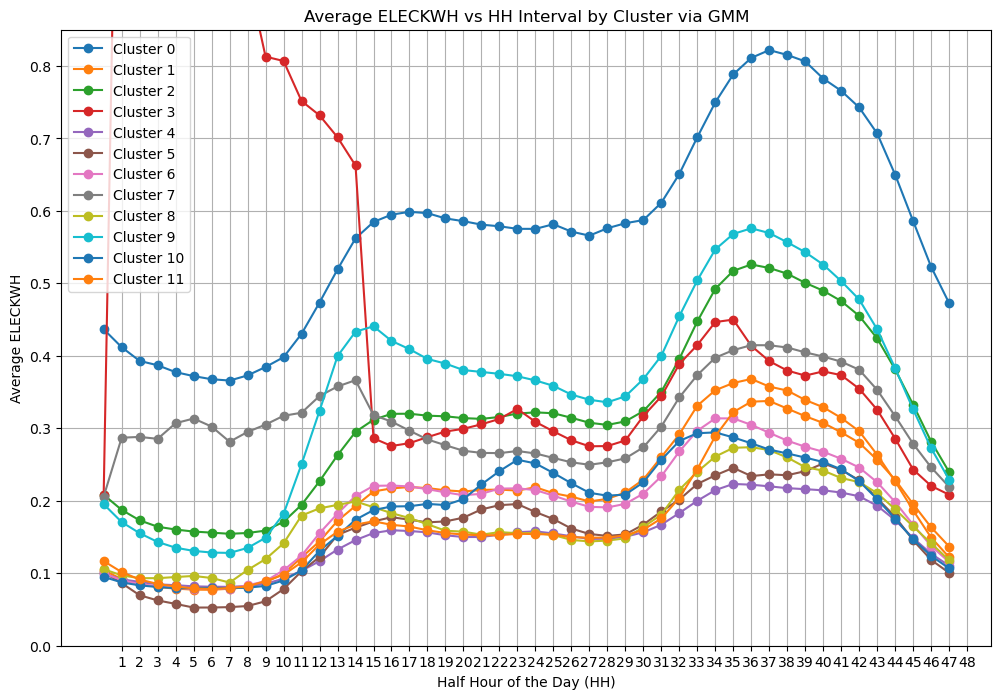

In [28]:
import matplotlib.pyplot as plt

# Group by Cluster and HH, and calculate the mean ELECKWH
clustered_means = df_with_clusters.groupby(['Cluster', 'HH'])['ELECKWH'].mean().reset_index()

# Plot each cluster
plt.figure(figsize=(12, 8))
for cluster in clustered_means['Cluster'].unique():
    cluster_data = clustered_means[clustered_means['Cluster'] == cluster]
    plt.plot(cluster_data['HH'], cluster_data['ELECKWH'], label=f'Cluster {cluster}', marker='o')

# Plot details
plt.title('Average ELECKWH vs HH Interval by Cluster via GMM')
plt.xlabel('Half Hour of the Day (HH)')
plt.ylabel('Average ELECKWH')
plt.xticks(range(1, 49))  # HH typically ranges from 1 to 48
plt.legend()
plt.ylim(0,.85)
plt.grid(True)
plt.show()

## PCA Analysis


[0.24855841 0.20540627]


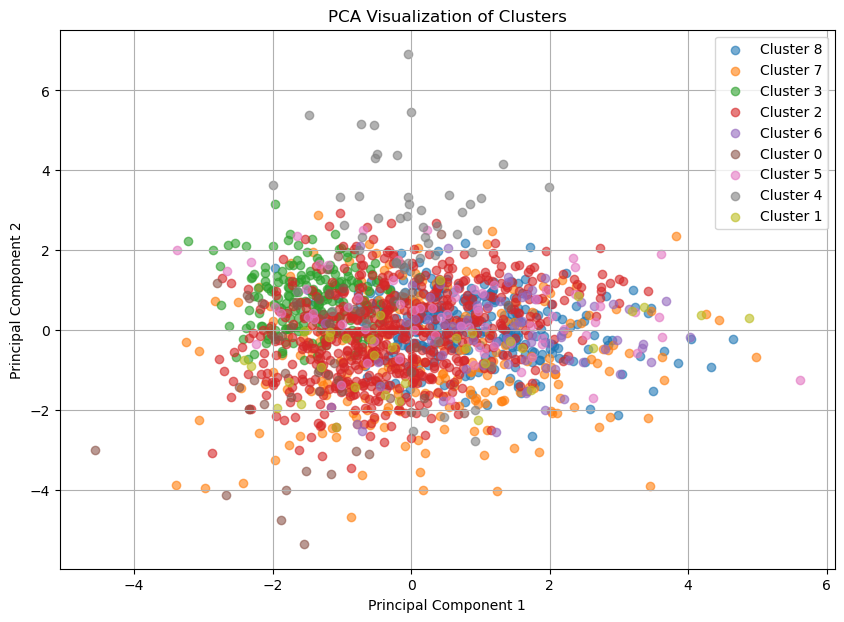

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Define the selected features for PCA
features = ['RME_bre', 'RME_eve', 'RME_day', 'RME_nig', 'RSD_avg', 'WScore', 'ADR', 'Avg_Day_Eve']
X = df100selected_features[features]

# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Apply PCA to reduce to 2 dimensions
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# Create a DataFrame with the PCA results and the cluster labels
df_pca = pd.DataFrame(X_pca, columns=['PCA1', 'PCA2'])
df_pca['Cluster'] = df100selected_features['Cluster']

# Plot the PCA-transformed data with cluster labels
plt.figure(figsize=(10, 7))
for cluster in df_pca['Cluster'].unique():
    plt.scatter(
        df_pca[df_pca['Cluster'] == cluster]['PCA1'],
        df_pca[df_pca['Cluster'] == cluster]['PCA2'],
        label=f'Cluster {cluster}',
        alpha=0.6
    )
print(pca.explained_variance_ratio_)


# Add plot details
plt.title('PCA Visualization of Clusters')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend()
plt.grid(True)
plt.show()


### Section 2.3.7 PCA w 2 components to evaluate the disimilarity of selected clusters

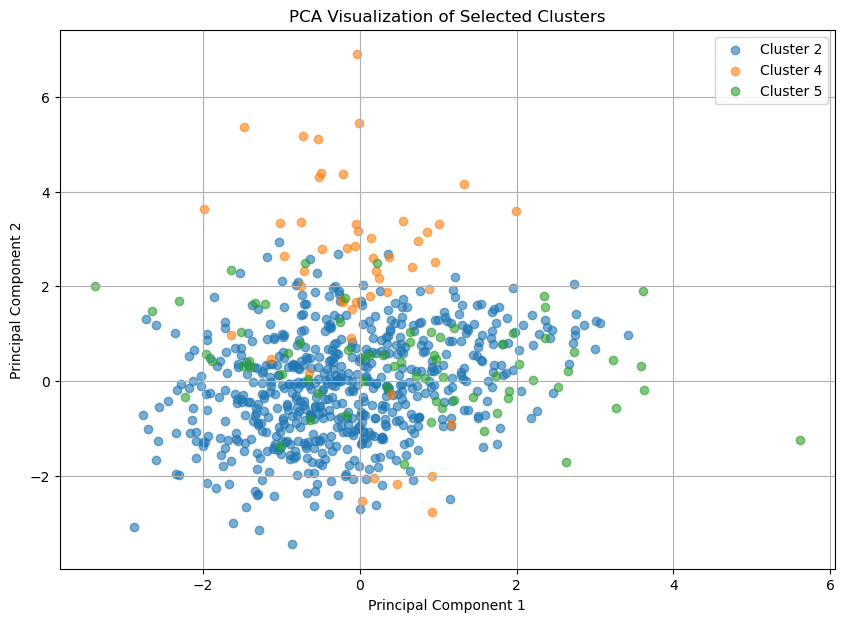

In [ ]:
import matplotlib.pyplot as plt

# Filter the DataFrame to keep only clusters 1, 2, 4, and 7
clusters_to_plot = [2, 4, 5]
df_pca_filtered = df_pca[df_pca['Cluster'].isin(clusters_to_plot)]

# Plot the PCA-transformed data with the specified cluster labels
plt.figure(figsize=(10, 7))
for cluster in clusters_to_plot:
    plt.scatter(
        df_pca_filtered[df_pca_filtered['Cluster'] == cluster]['PCA1'],
        df_pca_filtered[df_pca_filtered['Cluster'] == cluster]['PCA2'],
        label=f'Cluster {cluster}',
        alpha=0.6
    )

# Add plot details
plt.title('PCA Visualization of Selected Clusters')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend()
plt.grid(True)
plt.show()


## Results analysis

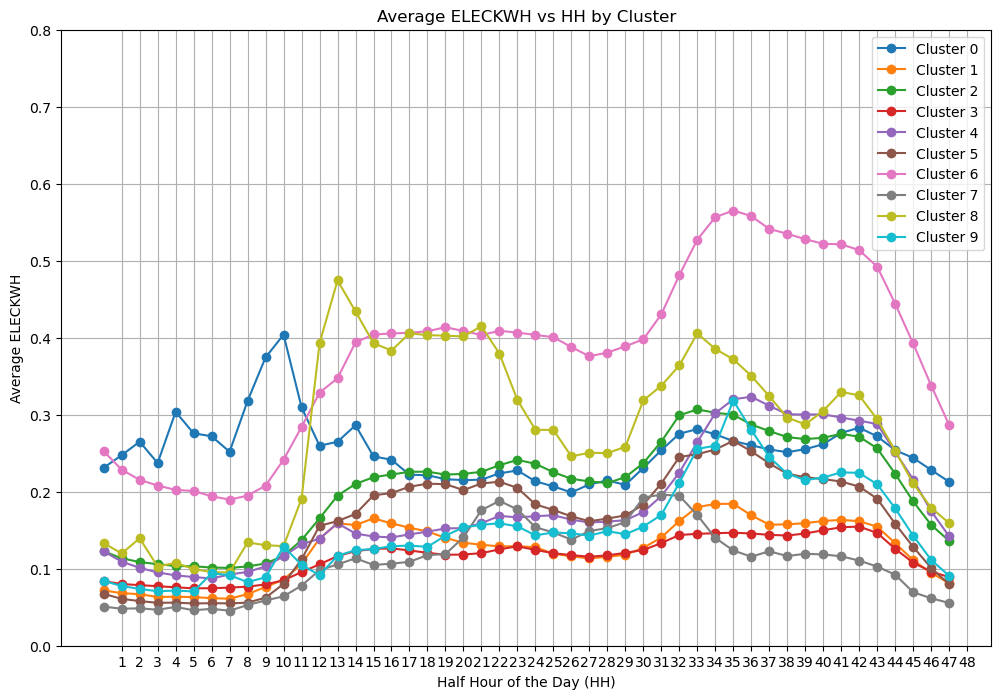

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

# Ensure 'HH' and 'ELECKWH' columns are in the dataframe
if 'HH' not in df100.columns or 'ELECKWH' not in df100.columns:
    raise KeyError("The dataframe must contain 'HH' and 'ELECKWH' columns.")

# Merge cluster information back into the original data (if not already included)
df_with_clusters = df100.merge(
    df100selected_features[['ANON_ID', 'Cluster']],
    on='ANON_ID',
    how='inner'
)

# Group by Cluster and HH, and calculate the mean ELECKWH
clustered_means = df_with_clusters.groupby(['Cluster', 'HH'])['ELECKWH'].mean().reset_index()

# Plot each cluster
plt.figure(figsize=(12, 8))
for cluster in clustered_means['Cluster'].unique():
    cluster_data = clustered_means[clustered_means['Cluster'] == cluster]
    plt.plot(cluster_data['HH'], cluster_data['ELECKWH'], label=f'Cluster {cluster}', marker='o')

# Plot details
plt.title('Average ELECKWH vs HH by Cluster')
plt.xlabel('Half Hour of the Day (HH)')
plt.ylabel('Average ELECKWH')
plt.xticks(range(1, 49))  # HH typically ranges from 1 to 48
plt.legend()
plt.ylim(0,0.8)
plt.grid(True)
plt.show()


/opt/miniconda3/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


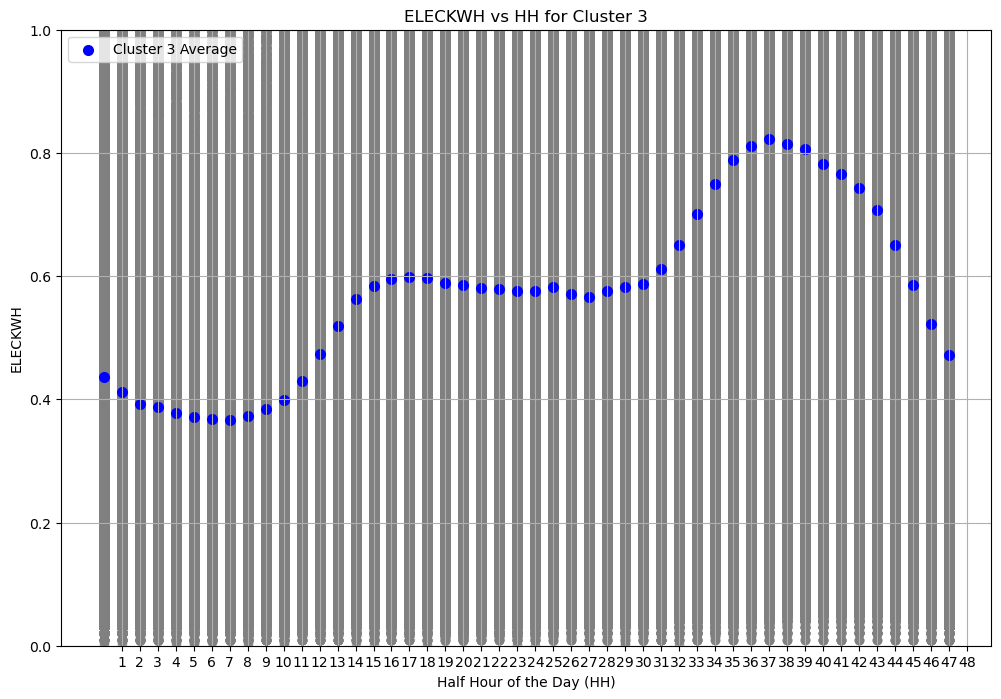

In [41]:
import matplotlib.pyplot as plt

# Filter the data for Cluster 3
cluster_3_data = df_with_clusters[df_with_clusters['Cluster'] == 3]

# Plot all ANON_IDs in grey
plt.figure(figsize=(12, 8))
for anon_id in cluster_3_data['ANON_ID'].unique():
    anon_data = cluster_3_data[cluster_3_data['ANON_ID'] == anon_id]
    plt.scatter(anon_data['HH'], anon_data['ELECKWH'], color='grey', alpha=0.6)

# Calculate the average ELECKWH for Cluster 3 by HH
cluster_3_avg = cluster_3_data.groupby('HH')['ELECKWH'].mean().reset_index()

# Plot the average for Cluster 3 in blue
plt.scatter(cluster_3_avg['HH'], cluster_3_avg['ELECKWH'], color='blue', linewidth=2, label='Cluster 3 Average')

# Plot details
plt.title('ELECKWH vs HH for Cluster 3')
plt.xlabel('Half Hour of the Day (HH)')
plt.ylabel('ELECKWH')
plt.xticks(range(1, 49))  # HH typically ranges from 1 to 48
plt.legend()
plt.ylim(0,1)
plt.grid(True)
plt.show()


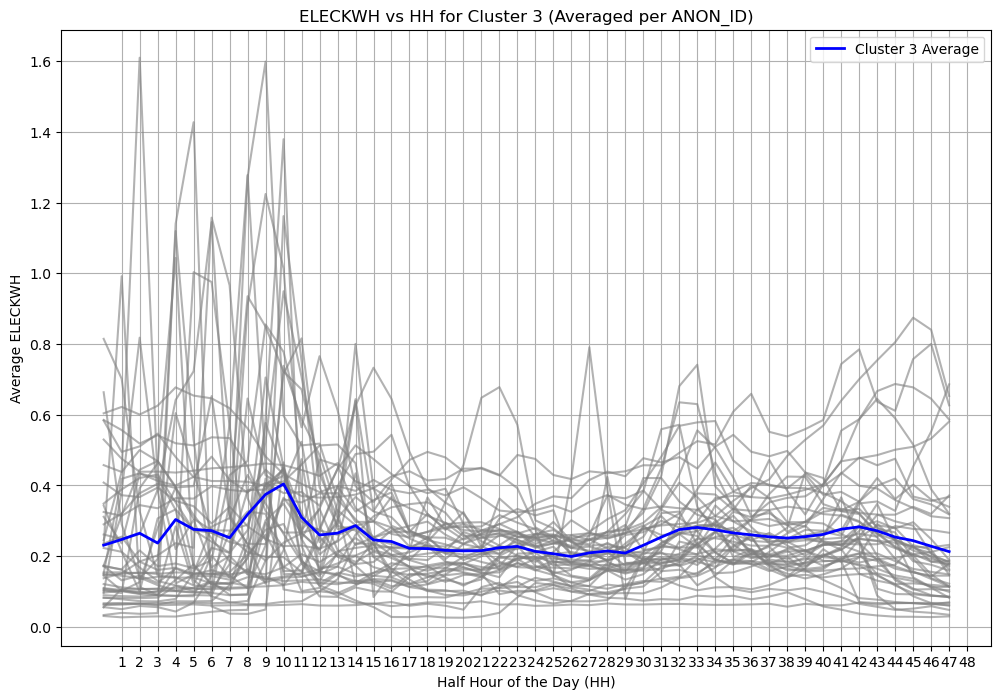

In [ ]:
import matplotlib.pyplot as plt

# Filter the data for Cluster 3
cluster_3_data = df_with_clusters[df_with_clusters['Cluster'] == 0]

# Calculate the average ELECKWH per HH for each ANON_ID
cluster_3_avg_by_anon = (
    cluster_3_data.groupby(['ANON_ID', 'HH'])['ELECKWH']
    .mean()
    .reset_index()
)

# Plot all ANON_IDs in grey
plt.figure(figsize=(12, 8))
for anon_id in cluster_3_avg_by_anon['ANON_ID'].unique():
    anon_data = cluster_3_avg_by_anon[cluster_3_avg_by_anon['ANON_ID'] == anon_id]
    plt.plot(anon_data['HH'], anon_data['ELECKWH'], color='grey', alpha=0.6)

# Calculate the cluster average ELECKWH per HH
cluster_3_avg = (
    cluster_3_avg_by_anon.groupby('HH')['ELECKWH']
    .mean()
    .reset_index()
)

# Plot the cluster average in blue
plt.plot(cluster_3_avg['HH'], cluster_3_avg['ELECKWH'], color='blue', linewidth=2, label='Cluster 3 Average')

# Plot details
plt.title('ELECKWH vs HH for Cluster 3 (Averaged per ANON_ID)')
plt.xlabel('Half Hour of the Day (HH)')
plt.ylabel('Average ELECKWH')
plt.xticks(range(1, 49))  # HH typically ranges from 1 to 48
plt.legend()
plt.grid(True)
plt.show()


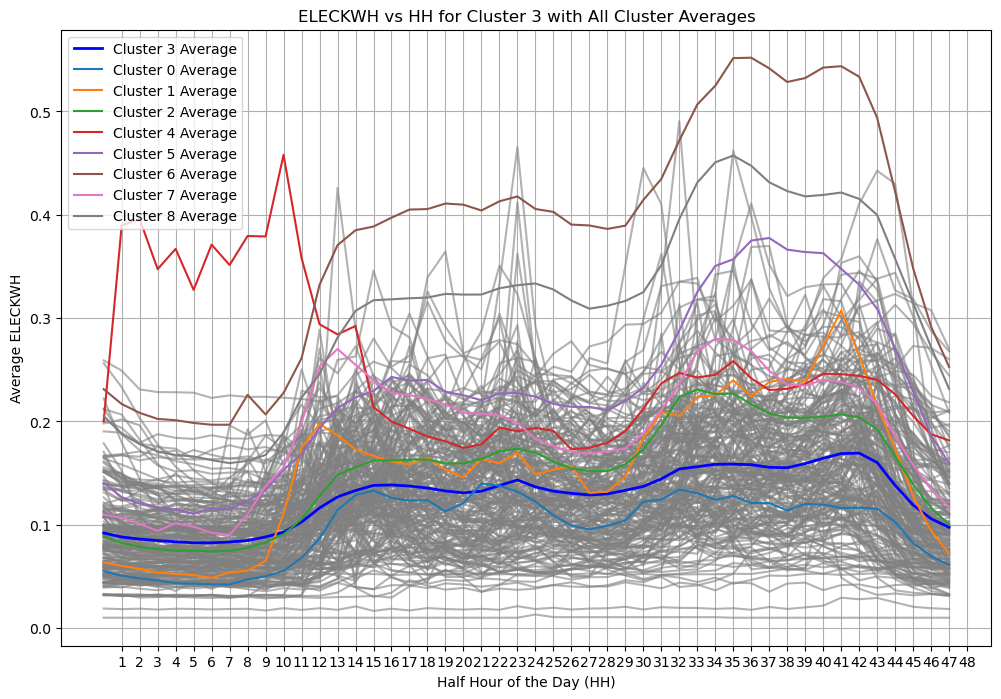

In [ ]:
import matplotlib.pyplot as plt

# Filter the data for Cluster 3
cluster_3_data = df_with_clusters[df_with_clusters['Cluster'] == 3]

# Calculate the average ELECKWH per HH for each ANON_ID in Cluster 3
cluster_3_avg_by_anon = (
    cluster_3_data.groupby(['ANON_ID', 'HH'])['ELECKWH']
    .mean()
    .reset_index()
)

# Calculate the average ELECKWH per HH for all clusters
all_clusters_avg = (
    df_with_clusters.groupby(['Cluster', 'HH'])['ELECKWH']
    .mean()
    .reset_index()
)

# Plot all ANON_IDs in Cluster 3 in grey
plt.figure(figsize=(12, 8))
for anon_id in cluster_3_avg_by_anon['ANON_ID'].unique():
    anon_data = cluster_3_avg_by_anon[cluster_3_avg_by_anon['ANON_ID'] == anon_id]
    plt.plot(anon_data['HH'], anon_data['ELECKWH'], color='grey', alpha=0.6)

# Plot the average for Cluster 3 in blue
cluster_3_avg = (
    cluster_3_avg_by_anon.groupby('HH')['ELECKWH']
    .mean()
    .reset_index()
)
plt.plot(cluster_3_avg['HH'], cluster_3_avg['ELECKWH'], color='blue', linewidth=2, label='Cluster 3 Average')

# Add averages for all other clusters in different colors
cluster_colors = ['red', 'green', 'orange', 'purple', 'brown']  # Define a color palette
for cluster in all_clusters_avg['Cluster'].unique():
    if cluster != 3:  # Exclude Cluster 3 (already plotted in blue)
        cluster_data = all_clusters_avg[all_clusters_avg['Cluster'] == cluster]
        plt.plot(cluster_data['HH'], cluster_data['ELECKWH'], label=f'Cluster {cluster} Average')

# Plot details
plt.title('ELECKWH vs HH for Cluster 3 with All Cluster Averages')
plt.xlabel('Half Hour of the Day (HH)')
plt.ylabel('Average ELECKWH')
plt.xticks(range(1, 49))  # HH typically ranges from 1 to 48
plt.legend()
plt.grid(True)
plt.show()


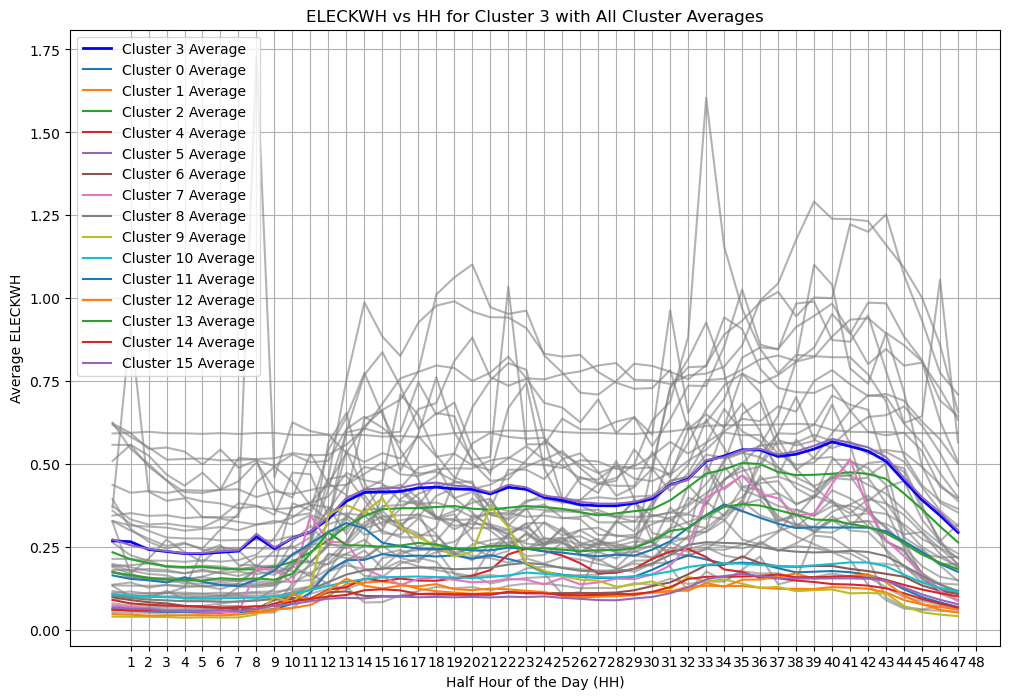

In [ ]:
import matplotlib.pyplot as plt

# Filter the data for Cluster 3
cluster_3_data = df_with_clusters[df_with_clusters['Cluster'] == 5]

# Calculate the average ELECKWH per HH for each ANON_ID in Cluster 3
cluster_3_avg_by_anon = (
    cluster_3_data.groupby(['ANON_ID', 'HH'])['ELECKWH']
    .mean()
    .reset_index()
)

# Calculate the average ELECKWH per HH for all clusters
all_clusters_avg = (
    df_with_clusters.groupby(['Cluster', 'HH'])['ELECKWH']
    .mean()
    .reset_index()
)

# Plot all ANON_IDs in Cluster 3 in grey
plt.figure(figsize=(12, 8))
for anon_id in cluster_3_avg_by_anon['ANON_ID'].unique():
    anon_data = cluster_3_avg_by_anon[cluster_3_avg_by_anon['ANON_ID'] == anon_id]
    plt.plot(anon_data['HH'], anon_data['ELECKWH'], color='grey', alpha=0.6)

# Plot the average for Cluster 3 in blue
cluster_3_avg = (
    cluster_3_avg_by_anon.groupby('HH')['ELECKWH']
    .mean()
    .reset_index()
)
plt.plot(cluster_3_avg['HH'], cluster_3_avg['ELECKWH'], color='blue', linewidth=2, label='Cluster 3 Average')

# Add averages for all other clusters in different colors
cluster_colors = ['red', 'green', 'orange', 'purple', 'brown']  # Define a color palette
for cluster in all_clusters_avg['Cluster'].unique():
    if cluster != 3:  # Exclude Cluster 3 (already plotted in blue)
        cluster_data = all_clusters_avg[all_clusters_avg['Cluster'] == cluster]
        plt.plot(cluster_data['HH'], cluster_data['ELECKWH'], label=f'Cluster {cluster} Average')

# Plot details
plt.title('ELECKWH vs HH for Cluster 3 with All Cluster Averages')
plt.xlabel('Half Hour of the Day (HH)')
plt.ylabel('Average ELECKWH')
plt.xticks(range(1, 49))  # HH typically ranges from 1 to 48
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
## import matplotlib.pyplot as plt

# Filter the data for Cluster 3
cluster_3_data = df_with_clusters[df_with_clusters['Cluster'] == 3]

# Calculate the average ELECKWH per HH for Cluster 3
cluster_3_avg = (
    cluster_3_data.groupby('HH')['ELECKWH']
    .mean()
    .reset_index()
    .rename(columns={'ELECKWH': 'Cluster_Avg_ELECKWH'})
)

# Merge the cluster average back with the individual ANON_ID data
cluster_3_data = cluster_3_data.merge(cluster_3_avg, on='HH', how='left')

# Calculate the absolute difference from the cluster average for each ANON_ID
cluster_3_data['Difference'] = cluster_3_data['ELECKWH'] - cluster_3_data['Cluster_Avg_ELECKWH']

# Calculate the mean difference per ANON_ID
anon_diff = (
    cluster_3_data.groupby('ANON_ID')['Difference']
    .mean()
    .reset_index()
    .rename(columns={'Difference': 'Mean_Difference'})
)

# Identify the ANON_IDs with the most positive and most negative differences
most_positive_anon = anon_diff.loc[anon_diff['Mean_Difference'].idxmax(), 'ANON_ID']
most_negative_anon = anon_diff.loc[anon_diff['Mean_Difference'].idxmin(), 'ANON_ID']

# Extract data for the identified ANON_IDs
positive_anon_data = (
    cluster_3_data[cluster_3_data['ANON_ID'] == most_positive_anon]
    .groupby('HH')['ELECKWH']
    .mean()
    .reset_index()
)

negative_anon_data = (
    cluster_3_data[cluster_3_data['ANON_ID'] == most_negative_anon]
    .groupby('HH')['ELECKWH']
    .mean()
    .reset_index()
)

# Plot the data
plt.figure(figsize=(12, 8))

# Plot the cluster average
plt.scatter(cluster_3_avg['HH'], cluster_3_avg['Cluster_Avg_ELECKWH'], color='blue', label='Cluster 3 Average', s=50)

# Plot the most positive ANON_ID
plt.scatter(positive_anon_data['HH'], positive_anon_data['ELECKWH'], color='green', label=f'Most Positive ANON_ID Avg: {most_positive_anon}', s=50)

# Plot the most negative ANON_ID
plt.scatter(negative_anon_data['HH'], negative_anon_data['ELECKWH'], color='red', label=f'Most Negative ANON_ID Avg: {most_negative_anon}', s=50)

# Plot details
plt.title('ELECKWH vs HH for Cluster 3: Average and Extremes (Averaged per HH)')
plt.xlabel('Half Hour of the Day (HH)')
plt.ylabel('Average ELECKWH')
plt.xticks(range(1, 49))  # HH typically ranges from 1 to 48
plt.legend()
plt.grid(True)
plt.show()


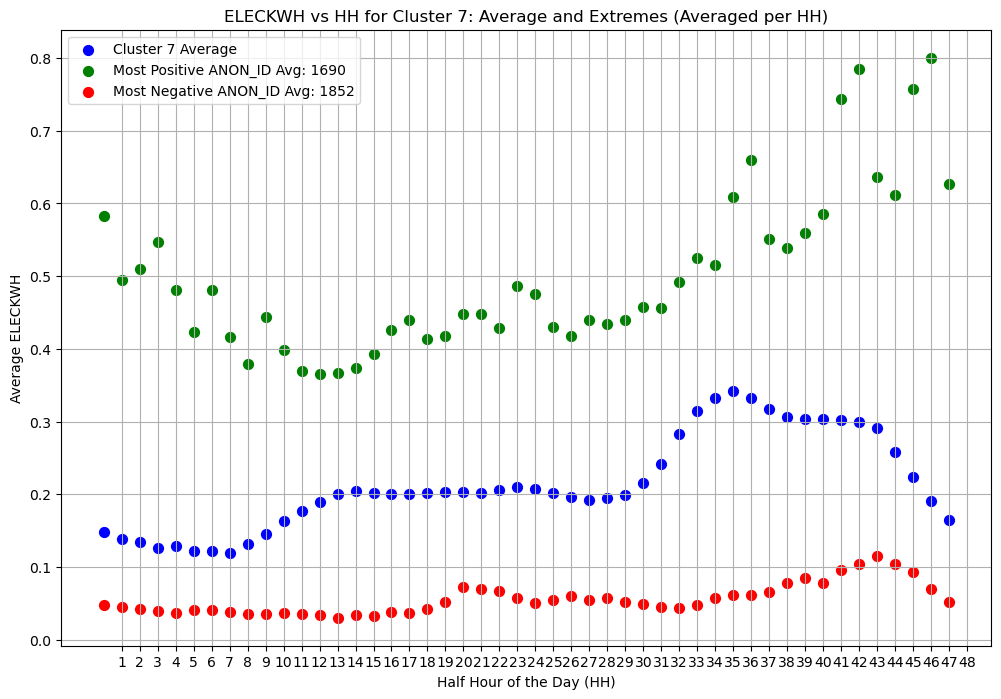

In [ ]:
import matplotlib.pyplot as plt

# Filter the data for Cluster 7
cluster_7_data = df_with_clusters[df_with_clusters['Cluster'] == 5]

# Calculate the average ELECKWH per HH for Cluster 7
cluster_7_avg = (
    cluster_7_data.groupby('HH')['ELECKWH']
    .mean()
    .reset_index()
    .rename(columns={'ELECKWH': 'Cluster_Avg_ELECKWH'})
)

# Merge the cluster average back with the individual ANON_ID data
cluster_7_data = cluster_7_data.merge(cluster_7_avg, on='HH', how='left')

# Calculate the absolute difference from the cluster average for each ANON_ID
cluster_7_data['Difference'] = cluster_7_data['ELECKWH'] - cluster_7_data['Cluster_Avg_ELECKWH']

# Calculate the mean difference per ANON_ID
anon_diff = (
    cluster_7_data.groupby('ANON_ID')['Difference']
    .mean()
    .reset_index()
    .rename(columns={'Difference': 'Mean_Difference'})
)

# Identify the ANON_IDs with the most positive and most negative differences
most_positive_anon = anon_diff.loc[anon_diff['Mean_Difference'].idxmax(), 'ANON_ID']
most_negative_anon = anon_diff.loc[anon_diff['Mean_Difference'].idxmin(), 'ANON_ID']

# Extract data for the identified ANON_IDs
positive_anon_data = (
    cluster_7_data[cluster_7_data['ANON_ID'] == most_positive_anon]
    .groupby('HH')['ELECKWH']
    .mean()
    .reset_index()
)

negative_anon_data = (
    cluster_7_data[cluster_7_data['ANON_ID'] == most_negative_anon]
    .groupby('HH')['ELECKWH']
    .mean()
    .reset_index()
)

# Plot the data
plt.figure(figsize=(12, 8))

# Plot the cluster average
plt.scatter(cluster_7_avg['HH'], cluster_7_avg['Cluster_Avg_ELECKWH'], color='blue', label='Cluster 7 Average', s=50)

# Plot the most positive ANON_ID
plt.scatter(positive_anon_data['HH'], positive_anon_data['ELECKWH'], color='green', label=f'Most Positive ANON_ID Avg: {most_positive_anon}', s=50)

# Plot the most negative ANON_ID
plt.scatter(negative_anon_data['HH'], negative_anon_data['ELECKWH'], color='red', label=f'Most Negative ANON_ID Avg: {most_negative_anon}', s=50)

# Plot details
plt.title('ELECKWH vs HH for Cluster 7: Average and Extremes (Averaged per HH)')
plt.xlabel('Half Hour of the Day (HH)')
plt.ylabel('Average ELECKWH')
plt.xticks(range(1, 49))  # HH typically ranges from 1 to 48
plt.legend()
plt.grid(True)
plt.show()


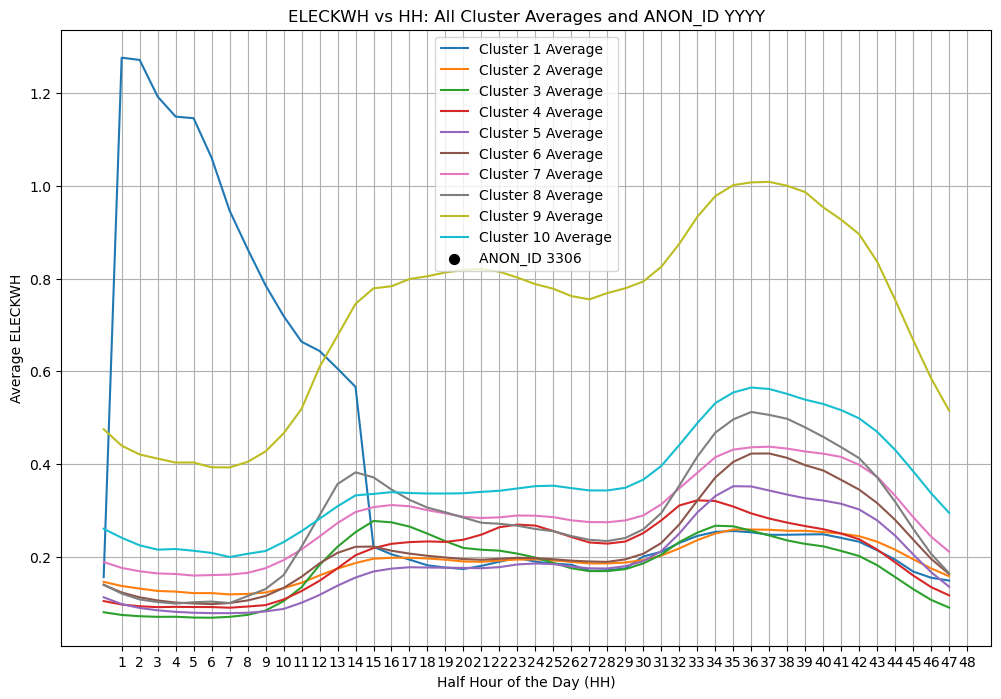

In [ ]:
import matplotlib.pyplot as plt

# Calculate the average ELECKWH per HH for each cluster
cluster_avg = (
    df_with_clusters.groupby(['Cluster', 'HH'])['ELECKWH']
    .mean()
    .reset_index()
    .rename(columns={'ELECKWH': 'Cluster_Avg_ELECKWH'})
)

# Extract data for ANON_ID 3306
anon_3306_data = (
    df_with_clusters[df_with_clusters['ANON_ID'] == 2177]
    .groupby('HH')['ELECKWH']
    .mean()
    .reset_index()
)

# Plot the data
plt.figure(figsize=(12, 8))

# Plot the cluster averages
cluster_colors = ['blue', 'red', 'green', 'purple', 'orange', 'brown', 'cyan']  # Define a palette for clusters
for cluster in cluster_avg['Cluster'].unique():
    cluster_data = cluster_avg[cluster_avg['Cluster'] == cluster]
    plt.plot(cluster_data['HH'], cluster_data['Cluster_Avg_ELECKWH'], label=f'Cluster {cluster} Average')

# Plot the ANON_ID 3306 data
plt.scatter(anon_3306_data['HH'], anon_3306_data['ELECKWH'], color='black', label='ANON_ID 3306', s=50)

# Plot details
plt.title('ELECKWH vs HH: All Cluster Averages and ANON_ID YYYY')
plt.xlabel('Half Hour of the Day (HH)')
plt.ylabel('Average ELECKWH')
plt.xticks(range(1, 49))  # HH typically ranges from 1 to 48
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
# Filter the data for ANON_ID = 3306
anon_3306_data = df100selected_features[df100selected_features['ANON_ID'] == 2177]

# Compute the mean values of the features for ANON_ID = 3306
anon_3306_means = anon_3306_data.mean(numeric_only=True).to_frame().T

# Add a column to identify it as ANON_ID = 3306
anon_3306_means['Cluster'] = 'ANON_ID YYYY'

# Reset index for the computed means to match cluster_means
anon_3306_means.reset_index(drop=True, inplace=True)

# Append the row to the cluster_means DataFrame
cluster_means_with_anon = pd.concat([cluster_means, anon_3306_means], ignore_index=True)


NameError: name 'df100selected_features' is not defined

In [ ]:
cluster_means_with_anon


Cluster   RME_bre   RME_eve   RME_day   RME_nig     RSD_avg    WScore  \
0             0  1.200000  1.190000  1.180000  0.560000   98.000000  0.030000   
1             1  1.060000  1.380000  1.040000  0.450000  113.810000  0.080000   
2             2  1.030000  1.360000  1.130000  0.590000   90.170000  0.070000   
3             3  1.050000  1.240000  1.070000  0.720000   56.410000 -0.010000   
4             4  0.870000  0.950000  0.800000  1.270000  104.560000  0.070000   
5             5  0.990000  1.440000  1.010000  0.640000   82.090000  0.100000   
6             6  1.010000  1.420000  1.080000  0.580000   68.260000  0.050000   
7             7  1.250000  1.250000  1.010000  0.640000  120.700000  0.040000   
8             8  0.990000  1.380000  1.080000  0.640000   71.300000  0.050000   
9  ANON_ID YYYY  0.984436  0.945091  1.162657  0.923318  115.210844 -0.080812   

   Avg_Daily_Max_Min_Diff  Avg_Day_Eve  ANON_ID  Cluster_HC  
0                0.530000     0.130000      NaN         NaN  
1                0.710000     0.220000      NaN         NaN  
2                0.700000     0.190000      NaN         NaN  
3                0.350000     0.150000      NaN         NaN  
4                1.260000     0.220000      NaN         NaN  
5                0.780000     0.290000      NaN         NaN  
6                1.030000     0.480000      NaN         NaN  
7                1.150000     0.220000      NaN         NaN  
8                1.030000     0.380000      NaN         NaN  
9                0.061209     0.027404   2177.0        10.0

In [ ]:
anon_ids_to_drop


[378,
 398,
 410,
 477,
 629,
 681,
 839,
 924,
 1221,
 1319,
 1355,
 1386,
 1436,
 1455,
 1458,
 1551,
 1571,
 1614,
 1664,
 1771,
 1846,
 1946,
 2002,
 2158,
 2207,
 2241,
 2369,
 2443,
 2558,
 2602,
 2629,
 2733,
 2846,
 3166,
 3212,
 3300,
 3439,
 3649,
 3928,
 4228,
 4280,
 4711,
 4827]